# Complementarity analysys

In [1]:
import sys
import socket
print("Working node:", socket.gethostname())
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

Working node: bbgn021


In [2]:
import pandas as pd
import math
from matplotlib_venn import venn2, venn3, venn3_circles
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns
from tqdm import tqdm
import warnings
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
names_dict = {"o3d" : "Oncodrive3D", 
             "hotmaps" : "3D clustering", 
             "clustl" : "Linear clustering", 
             "smreg" : "Domain enrichment", 
             "fml" : "Functional impact",
             "dndscv" : "Mut excess A", 
             "cbase" : "Mut excess B", 
             "mutpan" : "Mut excess C*"}

colors_dict = {names_dict["o3d"] : "#ffad48", 
               names_dict["hotmaps"] : "#024b79", 
               names_dict["clustl"] : "#43b7c2", 
               names_dict["smreg"] : "#c2f1ce", 
               names_dict["fml"] : "#bbd9f6",
               names_dict["dndscv"] : "#edd7c5", 
               names_dict["cbase"] : "#ffb8b3", 
               names_dict["mutpan"] : "#cee4d8"}

In [4]:
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
intogen_output = f"{datasets}/output/cancer_202404/intogen_output"
genetable_path = f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/data/results/{SUBDIR}/{RUN}.genetable.tsv"
oncotree_df = pd.read_csv(f"{datasets}/input/cancer_202404/oncotree.tsv", sep="\t")

genetable = pd.read_csv(genetable_path, sep="\t", dtype={1 : str, 2 : str, 3 : int})
genetable_subset = genetable[genetable["Cohort"].str.startswith("TCGA")]

lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]

In [19]:
### Clean plots
# !rm plots/bar_plots/all_methods/*.png
# !rm plots/bar_plots/clustering_methods/*.png
# !rm plots/number_detected/*.png
# !rm plots/venn_diagrams/all_methods/*.png
# !rm plots/venn_diagrams/clustering_methods/*.png

# Group cohorts by organ

In [5]:
def get_parent_tissues_dict(lst_tissues, oncotree_df):

    tissue_parent_dict = {}
    upper_ttypes = ["SOLID", "BOWEL", "OTHER", "CANCER", "NON_SOLID", np.nan]
    for tissue in lst_tissues:
        parent = tissue
        while parent not in upper_ttypes:
            if parent not in upper_ttypes:
                if parent not in upper_ttypes:
                    tissue_parent_dict[tissue] = parent
                    parent = oncotree_df[oncotree_df["ID"] == parent].PARENT.values
                    if len(parent) == 0:
                        parent = "OTHER"
                    else:
                        parent = parent[0]

    return tissue_parent_dict

# Get a dict to upper parent tissue for each tissue appearing in our cohorts
cohorts_tissue_parent_dict = get_parent_tissues_dict(cohort_df.CANCER_TYPE.unique(), oncotree_df)

# Get general cancer type for our cohorts
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df.CANCER_TYPE.apply(lambda x: cohorts_tissue_parent_dict[x])
cohort_df

COHORT  CANCER_TYPE PLATFORM  MUTATIONS  SAMPLES  \
0         HARTWIG_WGS_BLCA_2023         BLCA      WGS    5017561      144   
1          HARTWIG_WGS_EGC_2023          EGC      WGS     573540       21   
2          HARTWIG_WGS_LMS_2023          LMS      WGS     339549       43   
3    CBIOP_WGS_STAD_ONCOSG_2018         STAD      WGS     861309      147   
4      CBIOP_WXS_CM_VALLEN_2018          MEL      WXS     132960      151   
..                          ...          ...      ...        ...      ...   
266               TCGA_WXS_PRCC         PRCC      WXS      34566      276   
267               TCGA_WXS_PRAD         PRAD      WXS      34239      494   
268             TCGA_WXS_PLMESO       PLMESO      WXS       3980       82   
269        TCGA_WXS_SOFT_TISSUE  SOFT_TISSUE      WXS      31484      234   
270               TCGA_WXS_PGNG         PGNG      WXS       2666      178   

    GENERAL_CANCER_TYPE  
0               BLADDER  
1               STOMACH  
2           SOFT_TISSUE  
3               STOMACH  
4                  SKIN  
..                  ...  
266              KIDNEY  
267            PROSTATE  
268              PLEURA  
269         SOFT_TISSUE  
270         SOFT_TISSUE  

[271 rows x 6 columns]

# Complementarity bar plot

## Functions

In [14]:
def get_gene_cohort(x, gene_only=False):
    
    if gene_only:
        return x['Gene']
    else:
        return f"{x['Gene']}-{x['Cohort']}"


def get_hits_set_cohort(dict_hits, cohort, groups, clustering_groups=False):

    g1 = dict_hits["o3d"]
    if clustering_groups:
        # Define groups
        g2 = dict_hits["hotmaps"]
        g3 = dict_hits["clustl"]
        
        # Get intersecions, etc
        intsec_all = g1 & g2 & g3
        g1_only = g1 - g2 - g3
        g2_only = g2 - g1 - g3
        g3_only = g3 - g2 - g1
        intsec_g1_g2 = (g1 & g2) - g3
        intsec_g1_g3 = (g1 & g3) - g2
        intsec_g2_g3 = (g2 & g3) - g1
    
        groups_values = [g1_only, g2_only, g3_only, intsec_g1_g2, intsec_g1_g3, intsec_g2_g3, intsec_all]

    else:
        # Define groups
        g2 = dict_hits["hotmaps"] | dict_hits["clustl"]
        #g3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"]
        g3 = dict_hits["smreg"] | dict_hits["dndscv"] | dict_hits["mutpan"] | dict_hits["fml"] | dict_hits["cbase"] #| dict_hits["seismic"]
        
        # Get intersecions, etc
        intsec_all = g1 & g2 & g3
        g2_final = g2 - intsec_all
        g1_final = g1 - g2 - intsec_all
        g3_final = g3 - g1 - g2 - intsec_all
        
        groups_values = [intsec_all, g2_final, g1_final, g3_final]
        
    # Prepare df
    hits_set_cohort = [len(group) for group in groups_values]
    hits_set_cohort_df = pd.DataFrame({"Hits" : hits_set_cohort, "Group" : groups})
    hits_set_cohort_df["Cohort"] = cohort

    return hits_set_cohort_df


def get_hits_set(genetable_df, groups, lst_methods, clustering_groups=False):

    lst_df = []
    lst_unknown_df = []
    lst_cgc_df = []
    lst_fish_df = []
    
    for cohort in tqdm(genetable_df["Cohort"].unique()):
        method_cohort = genetable_df[genetable_df["Cohort"] == cohort].copy()

        dict_hits = {}
        dict_unknown_hits = {}
        dict_cgc_hits = {}
        dict_fish_hits = {}

        for method in lst_methods:
            method_hits_cohort = method_cohort[(method_cohort[f"{method}_qval"] < 0.01)]
            dict_hits[method] = set(list(method_hits_cohort.apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))
            dict_unknown_hits[method] = set(list(method_hits_cohort[(method_hits_cohort["CGC"] == 0) & 
                                                            (method_hits_cohort["Fish"] == 0)].apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))
            dict_cgc_hits[method] = set(list(method_hits_cohort[method_hits_cohort["CGC"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))
            dict_fish_hits[method] = set(list(method_hits_cohort[method_hits_cohort["Fish"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=True), axis=1).values))

        lst_df.append(get_hits_set_cohort(dict_hits, cohort, groups, clustering_groups))
        lst_unknown_df.append(get_hits_set_cohort(dict_unknown_hits, cohort, groups, clustering_groups))
        lst_cgc_df.append(get_hits_set_cohort(dict_cgc_hits, cohort, groups, clustering_groups))
        lst_fish_df.append(get_hits_set_cohort(dict_fish_hits, cohort, groups, clustering_groups))

    hits_set_df = pd.concat(lst_df).reset_index(drop=True)
    hits_unknown_set_df = pd.concat(lst_unknown_df).reset_index(drop=True)
    hits_cgc_set_df = pd.concat(lst_cgc_df).reset_index(drop=True)
    hits_fish_set_df = pd.concat(lst_fish_df).reset_index(drop=True)
    
    return hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df

In [15]:
def get_cohort_gene_mut(maf, missense_only=False):
    
    if missense_only:
        maf = maf[maf["Variant_Classification"] == "Missense_Mutation"]
    
    cohort_gene_mut = maf.groupby("Hugo_Symbol").apply(
        lambda x: len(x)).reset_index().rename(columns={"Hugo_Symbol" : "Gene", 0 : "Count"})
    cohort_gene_mut = cohort_gene_mut.sort_values("Count", ascending=False).reset_index(drop=True)
    
    return cohort_gene_mut


def get_union_intsec_cohort(genetable_cohort_df, lst_methods):

    # Drop any genes with all NaN or 1
    qval_cols = [f"{method}_qval" for method in lst_methods]
    df = genetable_cohort_df.copy().reset_index(drop=True)
    ix = df.replace(1, np.nan).dropna(subset=qval_cols, how='all').index.values
    df = df.iloc[ix,:]
    
    ix_hits = df[qval_cols] < 0.01
    ix_hits_union = ix_hits.any(1)
    ix_hits_intsec = ix_hits.all(1)
    n_union = sum(ix_hits_union)
    n_intsec = sum(ix_hits_intsec) 
    
    return n_union, n_intsec


def get_union_intsec_hits(gentable_df, maf_dir, lst_methods, mut_thr=1):
    df = gentable_df.copy()
    lst_df = []
    
    # Read MAF files outside the loop
    maf_data = {}
    for cohort in tqdm(df["Cohort"].unique()):
        maf = pd.read_csv(f"{maf_dir}/{cohort}.in.maf", sep="\t", low_memory=False)
        maf_data[cohort] = maf
    
    for cohort in tqdm(df["Cohort"].unique()):
        cohort_df = df[df["Cohort"] == cohort].copy()
        
        # Filter genes with more than 'mut_thr' mutations
        gene_mut = get_cohort_gene_mut(maf_data[cohort], missense_only=False)
        genes_to_keep = gene_mut[gene_mut["Count"] >= mut_thr].Gene.values
        cohort_df = cohort_df[cohort_df["Gene"].isin(genes_to_keep)]
        
        df_cgc = cohort_df[cohort_df["CGC"] == 1]
        cgc_all = len(df_cgc)
        cgc_union, cgc_intsec = get_union_intsec_cohort(df_cgc, lst_methods)
        cgc_union_ratio, cgc_intsec_ratio = get_union_intsec_cohort(df_cgc, lst_methods)

        df_fish = cohort_df[cohort_df["Fish"] == 1]
        fish_all = len(df_fish)
        fish_union, fish_intsec = get_union_intsec_cohort(df_fish, lst_methods)
        fish_union_ratio, fish_intsec_ratio = get_union_intsec_cohort(df_fish, lst_methods)

        lst_df.append((cohort, 
                       cgc_all, cgc_union, cgc_intsec, 
                       cgc_union_ratio, cgc_intsec_ratio, 
                       fish_all, fish_union, fish_intsec, 
                       fish_union_ratio, fish_intsec_ratio))

    return pd.DataFrame(lst_df, columns=["Cohort",
                                         "cgc_all", "cgc_union", "cgc_intsec", 
                                         "cgc_union_r", "cgc_intsec_r", 
                                         "fish_all", "fish_union", "fish_intsec", 
                                         "fish_union_r", "fish_intsec_r"]).reset_index(drop=True)

In [16]:
def barplot_hits_set(hits_set_df, 
                     intsec_union_df_o3d,
                     intsec_union_df_hotmaps,
                     color_dict, 
                     title="Detected genes across cohorts", 
                     figsize=(12, 8), 
                     plot_xticks=True, 
                     ec="black", 
                     xfsize=13, 
                     y_ax1_fsize=13,
                     y_ax2_fsize=13,
                     top_cohorts=None,
                     
                     legend_ax1=True,
                     legend_ax2=True,
                     
                     legend_ax1_fsize=10,
                     legend_ax2_fsize=12,
                     legend_ax1_ncol=1,
                     legend_ax2_ncol=1,
  
                     extract_cancer=False,
                     target="cgc",
                     
                     h_ratio=[1, 3],
                    
                     genes_thr=1):
    
    colors_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    hits_set_df=hits_set_df.copy()
    intsec_union_df_o3d=intsec_union_df_o3d.copy()
    intsec_union_df_hotmaps=intsec_union_df_hotmaps.copy()

    if extract_cancer:
        hits_set_df["Cohort"] = hits_set_df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
        intsec_union_df_o3d["Cohort"] = intsec_union_df_o3d["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
        intsec_union_df_hotmaps["Cohort"] = intsec_union_df_hotmaps["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])

    # Pivot the DataFrame to get 'Group' as columns and 'Cohort' as the index
    pivot_df = hits_set_df.pivot_table(index='Cohort', columns='Group', values='Hits', aggfunc='sum', fill_value=0)

    # Sort cohorts by detected genes
    cohort_totals = pivot_df.sum(axis=1).sort_values(ascending=False)
    cohort_totals = cohort_totals[cohort_totals >= genes_thr]
    pivot_df_sorted = pivot_df.loc[cohort_totals.index]
    intsec_union_df_o3d = intsec_union_df_o3d.set_index("Cohort")
    intsec_union_df_o3d = intsec_union_df_o3d.loc[cohort_totals.sort_values(ascending=False).index].fillna(0)
    intsec_union_df_hotmaps = intsec_union_df_hotmaps.set_index("Cohort")
    intsec_union_df_hotmaps = intsec_union_df_hotmaps.loc[cohort_totals.sort_values(ascending=False).index].fillna(0)
    if top_cohorts:
        pivot_df_sorted = pivot_df_sorted[:top_cohorts]
        intsec_union_df_o3d = intsec_union_df_o3d[:top_cohorts]
        intsec_union_df_hotmaps = intsec_union_df_hotmaps[:top_cohorts]

    ## Subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': h_ratio})

    # Barplot stacked by groups bottom
    pivot_df_sorted.plot(
        kind='bar', stacked=True, figsize=figsize, color=[color_dict[group] for group in pivot_df.columns], alpha=0.5, edgecolor=ec, ax=ax2)
    # Filled marked line plot above
    ax1.plot(intsec_union_df_hotmaps.index, intsec_union_df_hotmaps[f'{target}_union'], "-o", 
             color=colors_dic[names_dic["hotmaps"]], label='Methods ∪ with HotMAPS', lw=0.8, markersize=4, alpha=0.9)
    ax1.plot(intsec_union_df_hotmaps.index, intsec_union_df_hotmaps[f'{target}_intsec'], "--o", 
             color=colors_dic[names_dic["hotmaps"]], label='Methods ∩ with HotMAPS', lw=0.8, markersize=4, alpha=0.9)
    ax1.fill_between(intsec_union_df_hotmaps.index, intsec_union_df_o3d[f'{target}_intsec'], 
                     intsec_union_df_hotmaps[f'{target}_union'], color=colors_dic[names_dic["hotmaps"]], alpha=0.2)

    ax1.plot(intsec_union_df_o3d.index, intsec_union_df_o3d[f'{target}_union'], "-o", 
             color=colors_dic[names_dic["o3d"]], label='Methods ∪ with O3D', lw=0.8, markersize=4, alpha=0.9)
    ax1.plot(intsec_union_df_o3d.index, intsec_union_df_o3d[f'{target}_intsec'], "--o", 
             color=colors_dic[names_dic["o3d"]], label='Methods ∩ with O3D', lw=0.8, markersize=4, alpha=0.9)
    ax1.fill_between(intsec_union_df_o3d.index, intsec_union_df_o3d[f'{target}_intsec'], 
                     intsec_union_df_o3d[f'{target}_union'], color=colors_dic[names_dic["o3d"]], alpha=0.2)

    # Details
    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right') 
    else:
        plt.xticks([])

    if legend_ax1:
        
        legend_elements = [
            mlines.Line2D([], [], color='black', linestyle='-', label='Methods ∪'),
            mlines.Line2D([], [], color='black', linestyle='--', label='Methods ∩'),
            mlines.Line2D([], [], color=colors_dic[names_dic["o3d"]], marker='o', label=f"With {names_dic['o3d']}"),
            mlines.Line2D([], [], color=colors_dic[names_dic["hotmaps"]], marker='o', label=f"With {names_dic['hotmaps']}")
        ]
        
        # Add the legend with the custom elements
        ax1.legend(handles=legend_elements)

    else:
        ax1.legend('', frameon=False)
    if legend_ax2:
        ax2.legend(ncol=legend_ax2_ncol, fontsize=legend_ax2_fsize)
    else:
        ax2.legend('', frameon=False)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.xlabel('Cohort', fontsize=xfsize)
    ax2.set_ylabel('Count', fontsize=y_ax1_fsize)
    ax1.set_ylabel('Count', fontsize=y_ax2_fsize)
    plt.subplots_adjust(hspace=0.05) 
    plt.suptitle(title, fontsize=16)
    plt.show()
    

def barplot_hits_set_simple(hits_set_df, 
                            color_dict, 
                            title, 
                            figsize=(12, 7), 
                            plot_xticks=True, 
                            ec="black", 
                            xlab_fontsize=16, 
                            ylab_fontsize=16, 
                            xtick_fontsize=12, 
                            ytick_fontsize=15, 
                            top_cohorts=None, 
                            extract_cancer=False, 
                            legend_ncol=1, 
                            legend_fontsize=14, 
                            legend=True,
                            save=False,
                            ylabel="Genes count",
                            xlabel="Cohort",
                            filename="barplot_complementarity.png"):

    hits_set_df = hits_set_df.copy()
    if extract_cancer:
        hits_set_df["Cohort"] = hits_set_df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
        
    # Pivot the DataFrame to get 'Group' as columns and 'Cohort' as the index
    pivot_df = hits_set_df.pivot_table(index='Cohort', columns='Group', values='Hits', aggfunc='sum', fill_value=0)

    # Sort cohorts by detected genes
    cohort_totals = pivot_df.sum(axis=1)
    pivot_df_sorted = pivot_df.loc[cohort_totals.sort_values(ascending=False).index]
    if top_cohorts:
        pivot_df_sorted = pivot_df_sorted[:top_cohorts]

    # Sort cols in desired order
    groups_a = ["All", "O3D", "O3D-OncodriveCLUSTL", "O3D-HotMAPS", "HotMAPS", "HotMAPS-OncodriveCLUSTL", "OncodriveCLUSTL"]
    groups_b = ["All", "Oncodrive3D", "Clustering", "Others"]
    for groups in [groups_a, groups_b]:
        if all(item in groups for item in pivot_df_sorted.columns):
            pivot_df_sorted = pivot_df_sorted[groups]
        
    # Plot
    ax = pivot_df_sorted.plot(kind='bar', stacked=True, figsize=figsize, color=[color_dict[group] for group in pivot_df_sorted.columns], alpha=0.5, edgecolor=ec, lw=0.5)
    plt.xlabel(xlabel, fontsize=xlab_fontsize)
    plt.ylabel(ylabel, fontsize=ylab_fontsize)
    plt.title(title, fontsize=16)
    plt.yticks(fontsize=ytick_fontsize)
    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right', fontsize=xtick_fontsize) 
    else:
        plt.xticks([])
    if legend:
        plt.legend(fontsize=legend_fontsize, ncol=legend_ncol, frameon=False)
    else:
        plt.legend('', frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if save:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

## TCGA (main)

### All methods

In [20]:
# lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]
# groups = ["All", "Clustering", names_dict["o3d"], "Others"]
# colors = {names_dict["o3d"] : colors_dict[names_dict["o3d"]],
#           "Clustering" : "#5247a6", 
#           "Others" : "red", 
#           "All" : "green"}

# hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set(genetable_subset, groups, lst_methods, clustering_groups=False)

# barplot_hits_set_simple(hits_set_df, 
#                         figsize=(10, 5),
#                         color_dict=colors, title='Dected genes', 
#                         extract_cancer=True, 
#                         xtick_fontsize=11,
#                         top_cohorts=29, 
#                         save=True, 
#                         ylabel="Genes count",
#                         filename="plots_presentation/barplot_complementarity_tcga_all_methods.png")

In [19]:
# hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
# barplot_hits_set_simple(hits_unknown_set_df, 
#                         figsize=(10, 5),
#                         color_dict=colors, title='Dected not annotated genes', 
#                         extract_cancer=True, 
#                         xtick_fontsize=11,
#                         top_cohorts=29, 
#                         save=True, 
#                         ylabel="Not annotated genes count",
#                         filename="plots_presentation//unknown_barplot_complementarity_tcga_all_methods.png")

In [21]:
# barplot_hits_set_simple(hits_cgc_set_df, 
#                         figsize=(10, 5),
#                         color_dict=colors, 
#                         title='Dected CGC genes', 
#                         extract_cancer=True, 
#                         xtick_fontsize=11,
#                         top_cohorts=29, 
#                         ylabel="CGC genes count",
#                         save=True, 
#                         filename="plots/bar_plots/all_methods/cgc_barplot_complementarity_tcga_all_methods.png")

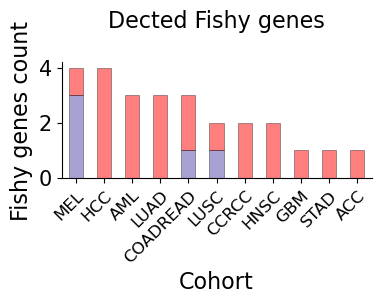

In [127]:
barplot_hits_set_simple(hits_fish_set_df, color_dict=colors, title='Dected Fishy genes\n', 
                 top_cohorts=11, 
                 figsize=(4, 1.5), 
                 legend_ncol=1, 
                 legend_fontsize=8, 
                 extract_cancer=True, 
                 legend=False, 
                 ylabel="Fishy genes count",
                 save=False, 
                 filename="plots/bar_plots/all_methods/fishy_barplot_complementarity_tcga_all_methods.png")

### Clustering methods

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.91it/s]


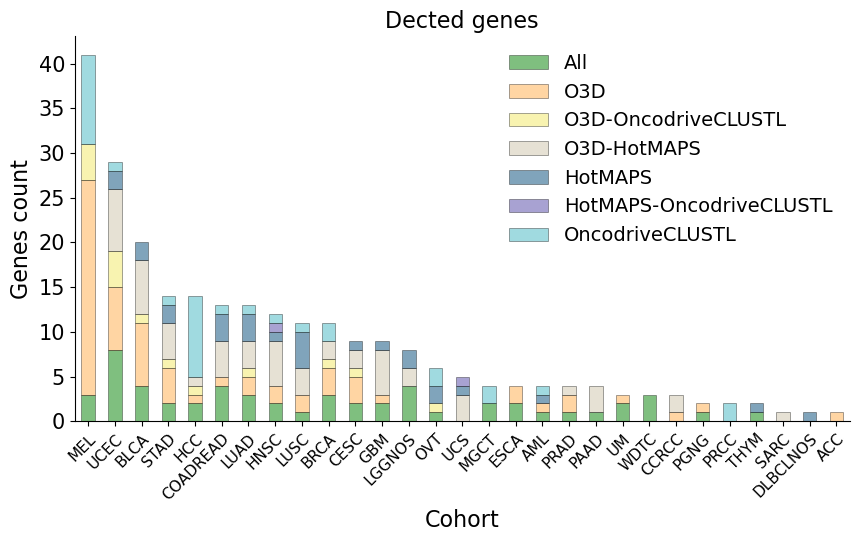

In [147]:
## TCGA
lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]
groups = ["O3D", "HotMAPS", "OncodriveCLUSTL", "O3D-HotMAPS", "O3D-OncodriveCLUSTL", "HotMAPS-OncodriveCLUSTL", "All"]
colors = {"O3D" : colors_dic["Oncodrive3D"],
          "HotMAPS" : colors_dic["HotMAPS"], 
          "OncodriveCLUSTL" : colors_dic["OncodriveCLUSTL"], 
          "O3D-HotMAPS" : "#cec5ab", 
          "O3D-OncodriveCLUSTL" : "#f2e963", 
          "HotMAPS-OncodriveCLUSTL" : "#5247a6", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set(genetable_subset, groups, lst_methods, clustering_groups=True)
barplot_hits_set_simple(hits_set_df, 
                        color_dict=colors, 
                        figsize=(10, 5),
                        xtick_fontsize=11,
                        title='Dected genes', 
                        extract_cancer=True, 
                        top_cohorts=29,
                        ylabel="Genes count",
                        save=True, 
                        filename="plots/bar_plots/clustering_methods/cgc_barplot_complementarity_clustering_tcga_all_methods.png")

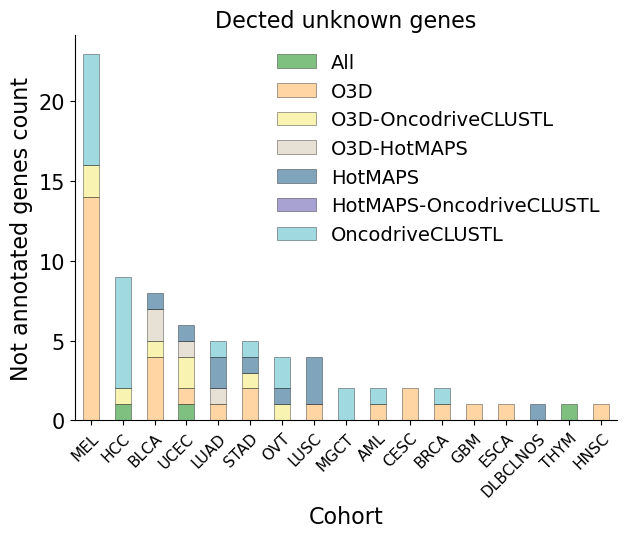

In [150]:
hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_unknown_set_df, 
                        color_dict=colors, 
                        figsize=(7, 5),
                        xtick_fontsize=11,
                        title='Dected unknown genes', 
                        extract_cancer=True, 
                        top_cohorts=29,
                        ylabel="Not annotated genes count",
                        save=True, 
                        filename="plots/bar_plots/clustering_methods/unknown_barplot_complementarity_clustering_tcga_clustl_methods.png")

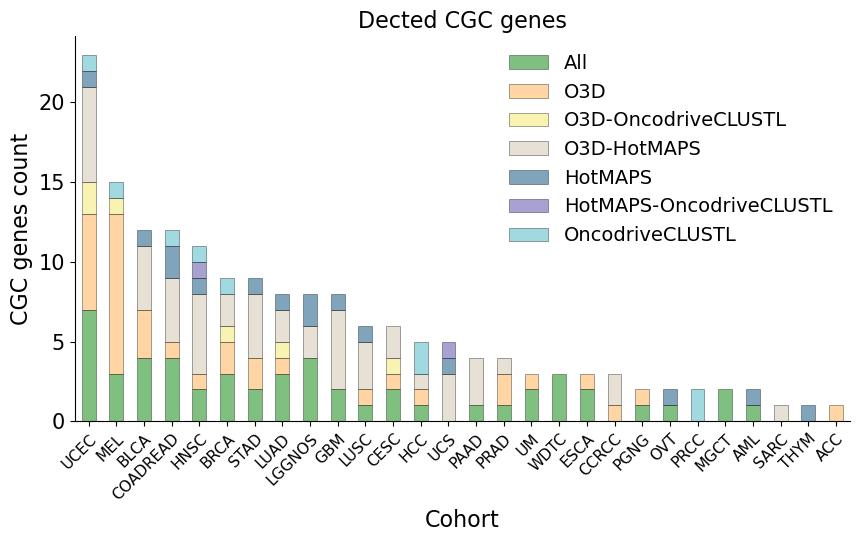

In [149]:
hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_cgc_set_df, 
                        color_dict=colors, 
                        figsize=(10, 5),
                        xtick_fontsize=11,
                        title='Dected CGC genes', 
                        extract_cancer=True, 
                        top_cohorts=29,
                        ylabel="CGC genes count",
                        save=True, 
                        filename="plots/bar_plots/clustering_methods/cgc_barplot_complementarity_clustering_tcga_clustl_methods.png")

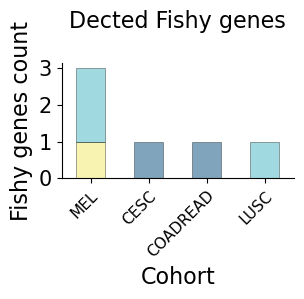

In [154]:
hits_fish_set_df = hits_fish_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_fish_set_df, 
                        color_dict=colors, 
                        xtick_fontsize=11,
                        title='Dected Fishy genes\n', 
                        top_cohorts=6, figsize=(3, 1.5), legend_ncol=1, legend_fontsize=8, extract_cancer=True, legend=False,
                        ylabel="Fishy genes count",
                        save=False, 
                        filename="plots/bar_plots/clustering_methods/fishy_barplot_complementarity_clustering_tcga_clustl_methods.png")

## All cohorts (supplementary)
__(with at least one detected gene)__

### All methods

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [01:03<00:00,  3.37it/s]


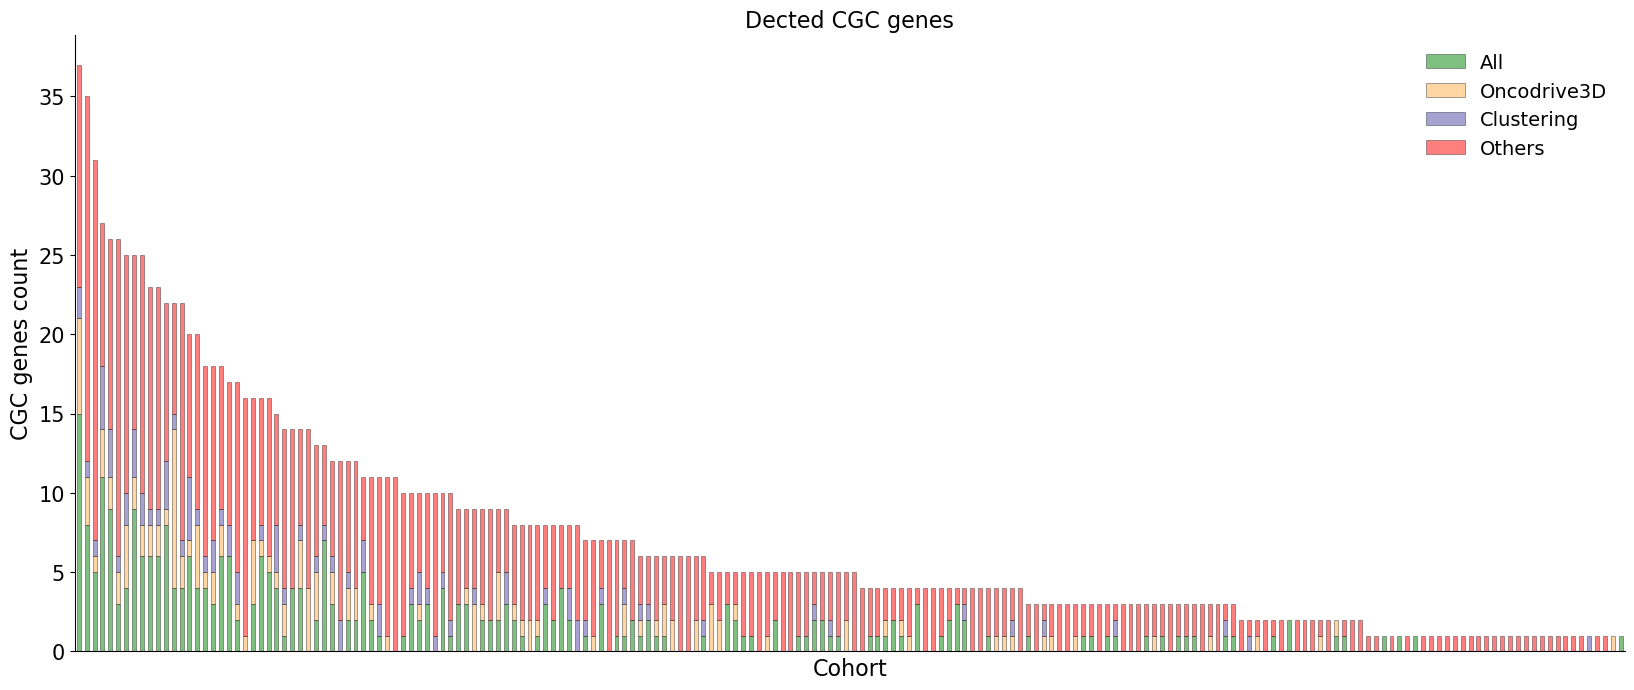

In [128]:
## All cohorts (with at least one detected gene)
groups = ["All", "Clustering", "Oncodrive3D", "Others"]
colors = {"Oncodrive3D" : colors_dic[names_dic["o3d"]],
          "Clustering" : "#5247a6", 
          "Others" : "red", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set(genetable, groups, lst_methods, clustering_groups=False)

hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_cgc_set_df, color_dict=colors, title='Dected CGC genes', 
                        ylabel="CGC genes count",
                        figsize=(20, 8), plot_xticks=False)

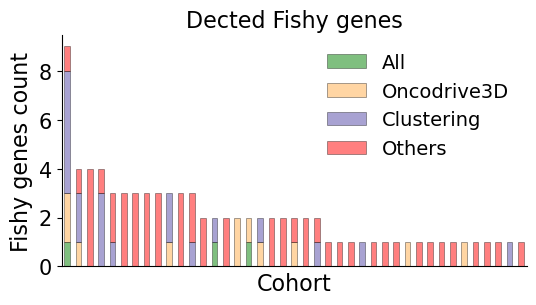

In [129]:
hits_fish_set_df = hits_fish_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_fish_set_df, color_dict=colors, title='Dected Fishy genes', 
                        ylabel="Fishy genes count",
                        figsize=(6, 3), plot_xticks=False)

### Clustering methods

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [01:03<00:00,  3.37it/s]


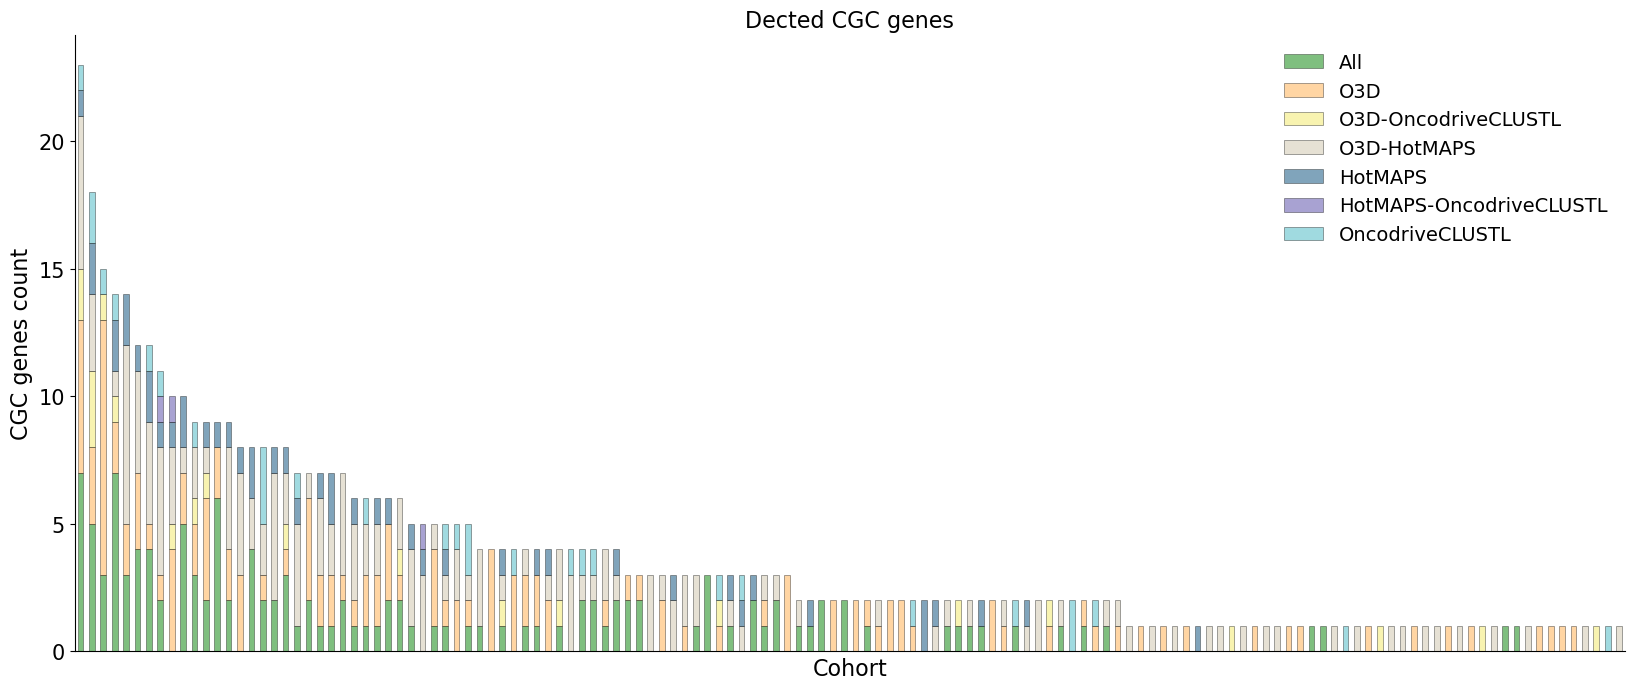

In [130]:
## All cohorts
groups = ["O3D", "HotMAPS", "OncodriveCLUSTL", "O3D-HotMAPS", "O3D-OncodriveCLUSTL", "HotMAPS-OncodriveCLUSTL", "All"]
colors = {"O3D" : colors_dic["Oncodrive3D"],
          "HotMAPS" : colors_dic["HotMAPS"], 
          "OncodriveCLUSTL" : colors_dic["OncodriveCLUSTL"], 
          "O3D-HotMAPS" : "#cec5ab", 
          "O3D-OncodriveCLUSTL" : "#f2e963", 
          "HotMAPS-OncodriveCLUSTL" : "#5247a6", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set(genetable, groups, lst_methods, clustering_groups=True)

hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_cgc_set_df, color_dict=colors, title='Dected CGC genes', ylabel="CGC genes count",
                 figsize=(20, 8), plot_xticks=False)

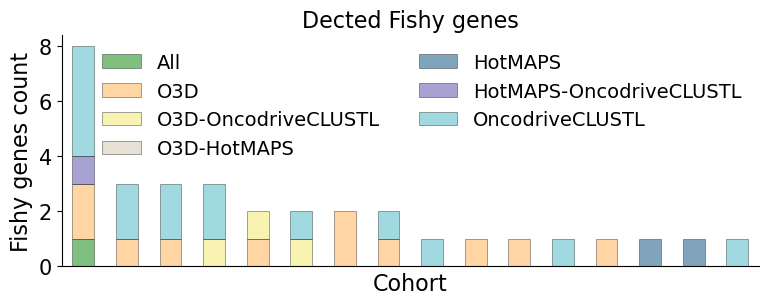

In [131]:
hits_fish_set_df = hits_fish_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
barplot_hits_set_simple(hits_fish_set_df, color_dict=colors, title='Dected Fishy genes', 
                        ylabel="Fishy genes count", legend_ncol=2,
                        figsize=(9, 3), plot_xticks=False)

## All cohorts grouped by organ

In [9]:
def get_gene_cohort(x, gene_only=False, organ=None):
    
    if gene_only:
        return x['Gene']
    else:
        if organ:
            return f"{x['Gene']}-{organ}"
        else:
            return f"{x['Gene']}-{x['Cohort']}"
        

def get_hits_set_organ(genetable_df, groups, lst_methods, cohort_df, clustering_groups=False, gene_only=True, gene_organ=False):

    lst_df = []
    lst_unknown_df = []
    lst_cgc_df = []
    lst_fish_df = []
    
    for organ in tqdm(cohort_df["GENERAL_CANCER_TYPE"].unique()):
        organ_cohorts = cohort_df.loc[cohort_df["GENERAL_CANCER_TYPE"] == organ, "COHORT"].unique()
        method_organ = genetable_df[genetable_df["Cohort"].isin(organ_cohorts)].copy()
        
        dict_hits = {}
        dict_unknown_hits = {}
        dict_cgc_hits = {}
        dict_fish_hits = {}

        for method in lst_methods:
            method_hits_cohort = method_organ[(method_organ[f"{method}_qval"] < 0.01)]
            dict_hits[method] = set(list(method_hits_cohort.apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))
            dict_unknown_hits[method] = set(list(method_hits_cohort[(method_hits_cohort["CGC"] == 0) & 
                                                            (method_hits_cohort["Fish"] == 0)].apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))
            dict_cgc_hits[method] = set(list(method_hits_cohort[method_hits_cohort["CGC"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))
            dict_fish_hits[method] = set(list(method_hits_cohort[method_hits_cohort["Fish"] == 1].apply(
                lambda x: get_gene_cohort(x, gene_only=gene_only, organ=gene_organ), axis=1).values))

        lst_df.append(get_hits_set_cohort(dict_hits, organ, groups, clustering_groups))
        lst_unknown_df.append(get_hits_set_cohort(dict_unknown_hits, organ, groups, clustering_groups))
        lst_cgc_df.append(get_hits_set_cohort(dict_cgc_hits, organ, groups, clustering_groups))
        lst_fish_df.append(get_hits_set_cohort(dict_fish_hits, organ, groups, clustering_groups))

    hits_set_df = pd.concat(lst_df).reset_index(drop=True)
    hits_unknown_set_df = pd.concat(lst_unknown_df).reset_index(drop=True)
    hits_cgc_set_df = pd.concat(lst_cgc_df).reset_index(drop=True)
    hits_fish_set_df = pd.concat(lst_fish_df).reset_index(drop=True)
    
    return hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df

### All methods

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.25it/s]


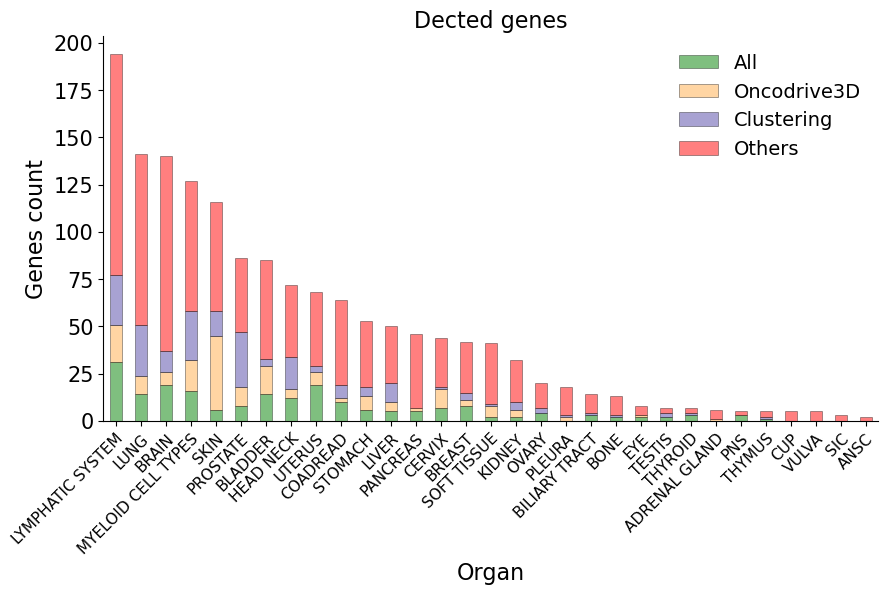

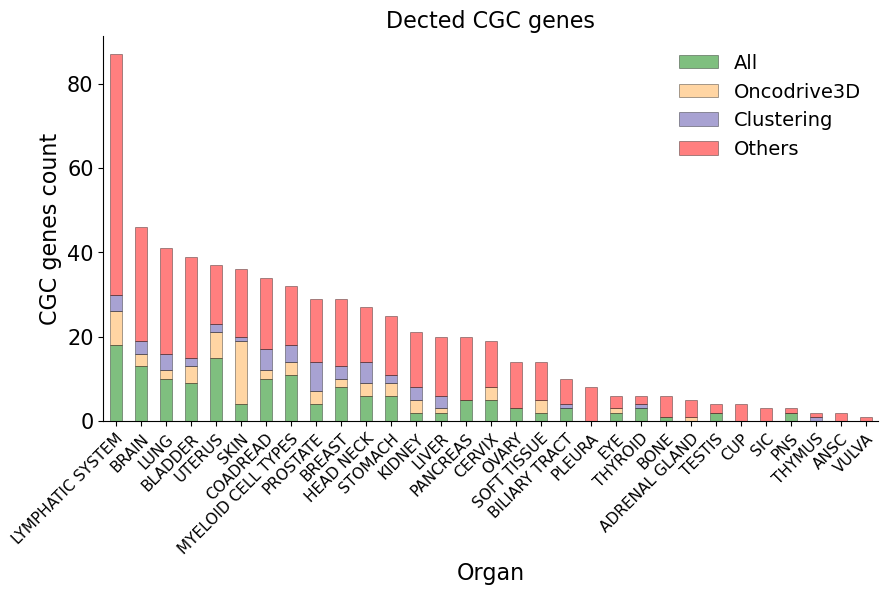

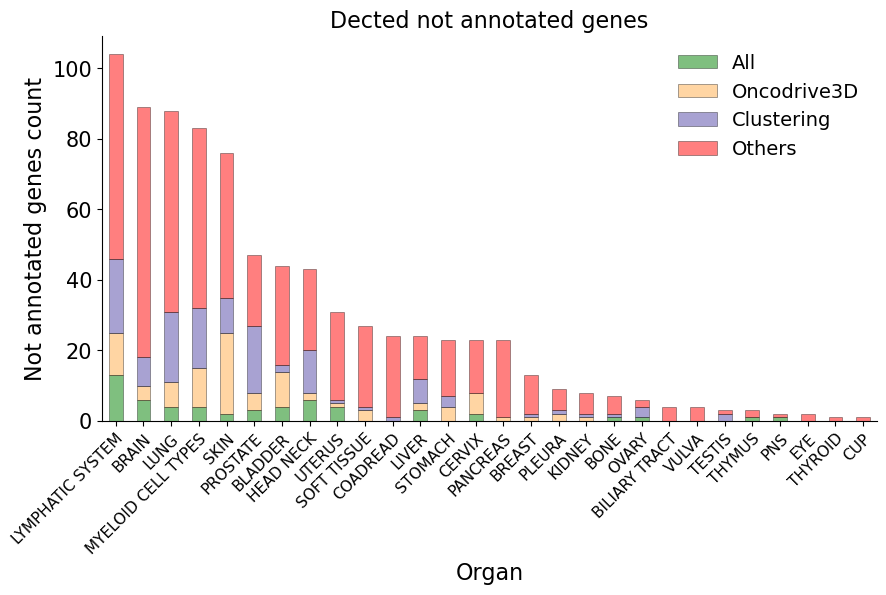

In [11]:
## All cohorts
groups = ["All", "Clustering", "Oncodrive3D", "Others"]
colors = {"Oncodrive3D" : colors_dic[names_dic["o3d"]],
          "Clustering" : "#5247a6", 
          "Others" : "red", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set_organ(genetable, groups, lst_methods, cohort_df, 
                                                                                         clustering_groups=False, gene_only=True, gene_organ=False)

# All genes
hits_set_df = hits_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("_", " ")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")

barplot_hits_set_simple(hits_set_df, 
                        color_dict=colors, 
                        title='Dected genes', 
                        ylabel="Genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True)

# CGC genes
hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("_", " ")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")

barplot_hits_set_simple(hits_cgc_set_df, 
                        color_dict=colors, 
                        title='Dected CGC genes', 
                        ylabel="CGC genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True)

# Not annotated genes
hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("_", " ")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")

barplot_hits_set_simple(hits_unknown_set_df, 
                        color_dict=colors, 
                        title='Dected not annotated genes', 
                        ylabel="Not annotated genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True)

### Clustering methods

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:07<00:00,  4.27it/s]


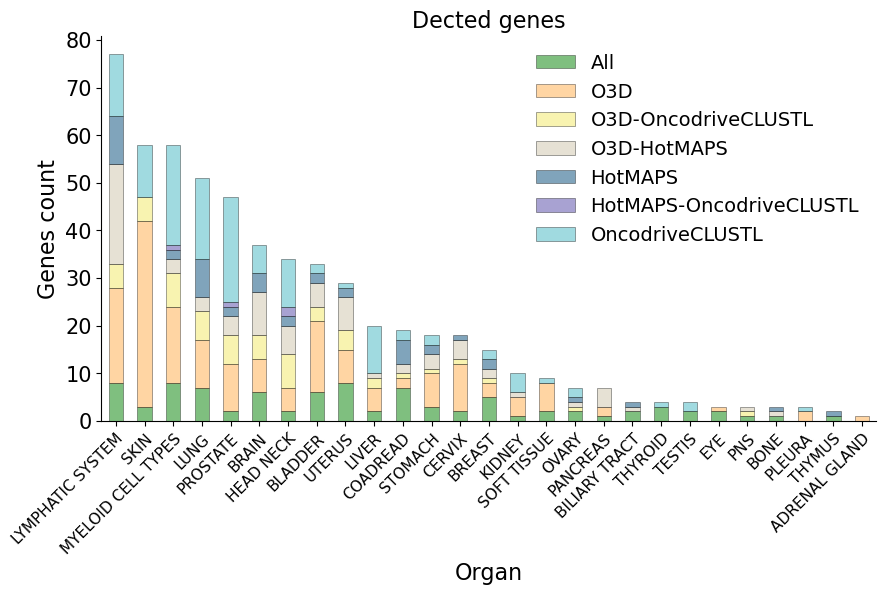

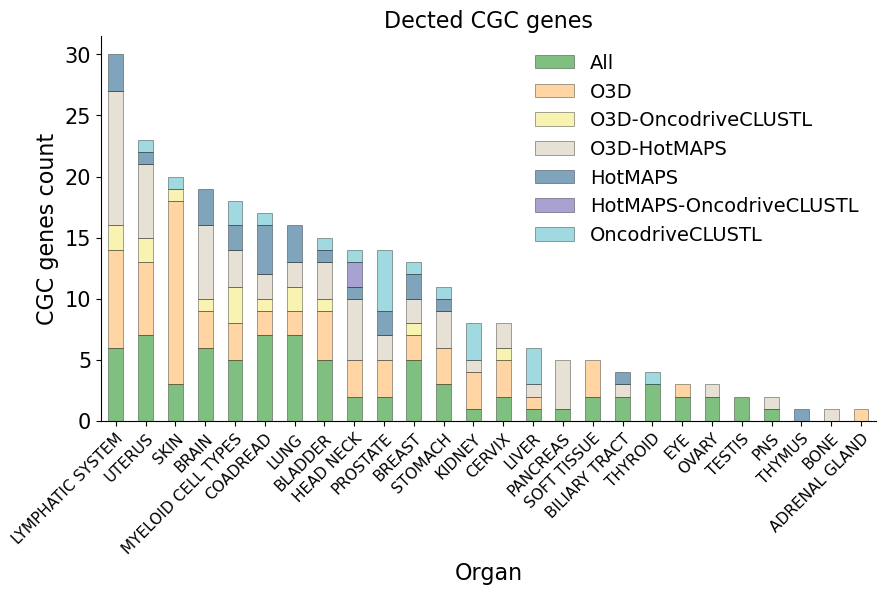

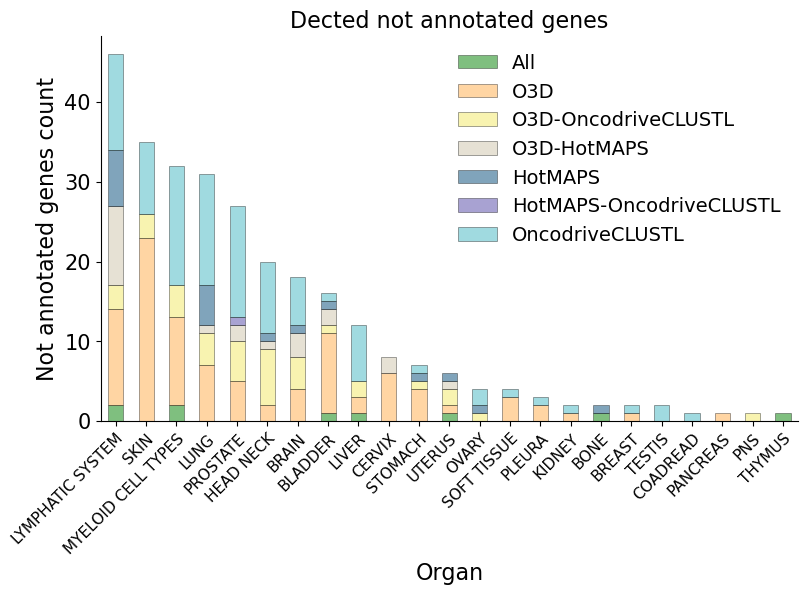

In [12]:
## All cohorts
groups = ["O3D", "HotMAPS", "OncodriveCLUSTL", "O3D-HotMAPS", "O3D-OncodriveCLUSTL", "HotMAPS-OncodriveCLUSTL", "All"]
colors = {"O3D" : colors_dic["Oncodrive3D"],
          "HotMAPS" : colors_dic["HotMAPS"], 
          "OncodriveCLUSTL" : colors_dic["OncodriveCLUSTL"], 
          "O3D-HotMAPS" : "#cec5ab", 
          "O3D-OncodriveCLUSTL" : "#f2e963", 
          "HotMAPS-OncodriveCLUSTL" : "#5247a6", 
          "All" : "green"}

hits_set_df, hits_unknown_set_df, hits_cgc_set_df, hits_fish_set_df = get_hits_set_organ(genetable, groups, lst_methods, cohort_df, 
                                                                                         clustering_groups=True, gene_only=True, gene_organ=False)

# All genes
hits_set_df = hits_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("_", " ")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_set_df.Cohort = hits_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")

barplot_hits_set_simple(hits_set_df, 
                        color_dict=colors, 
                        title='Dected genes', 
                        ylabel="Genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True)

# CGC genes
hits_cgc_set_df = hits_cgc_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("_", " ")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_cgc_set_df.Cohort = hits_cgc_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")

barplot_hits_set_simple(hits_cgc_set_df, 
                        color_dict=colors, 
                        title='Dected CGC genes', 
                        ylabel="CGC genes count",
                        xlabel="Organ",
                        figsize=(10, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True)

# Not annotated genes
hits_unknown_set_df = hits_unknown_set_df.groupby("Cohort").filter(lambda x: x["Hits"].sum() > 0).reset_index(drop=True)
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("_", " ")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("LYMPH", "LYMPHATIC SYSTEM")
hits_unknown_set_df.Cohort = hits_unknown_set_df.Cohort.str.replace("MYELOID", "MYELOID CELL TYPES")

barplot_hits_set_simple(hits_unknown_set_df, 
                        color_dict=colors, 
                        title='Dected not annotated genes', 
                        ylabel="Not annotated genes count",
                        xlabel="Organ",
                        figsize=(9, 5),
                        xtick_fontsize=11, 
                        plot_xticks=True)

# Number of detected genes

## Functions

In [10]:
def get_unique_hits(df, qval_lst_name, df_to_exclude=None):
    
    # Initialize a dictionary to store the sums
    sums_by_method = {}

    # Iterate through each q-value column
    for column in qval_lst_name:
        # Filter rows where the p-value is lower than 0.01 and drop duplicates in the 'Gene' column
        method_df = df[df[column] < 0.01].drop_duplicates(subset='Gene')

        # Remove genes that are already counted to avoid counting them twice
        if df_to_exclude is not None:
            method_genes_to_exclude = df_to_exclude[df_to_exclude[column] < 0.01].Gene.unique()
            ix_filter = ~method_df.Gene.isin(method_genes_to_exclude)
            method_df = method_df[ix_filter]

        # Store the sum in the dictionary with the method name as the key
        sums_by_method[column] = len(method_df)
        
    return pd.DataFrame(sums_by_method, index=[0])
    

def get_hits_summary(cohort_df, 
                     lst_name, 
                     alpha = 0.01, 
                     unknown = True, 
                     unique = False, 
                     df_to_exclude = None):
    """
    Get the count of significant genes for each method 
    for both p-values and q-values, all genes and CGC genes.
    """

    # Get qvals hits, CGC, and Fishy count
    
    qval_lst_name = [f"{name}_qval" for name in lst_name]
    
    if unique:
        cohort_hits_cgc = cohort_df[(cohort_df["CGC"] == 1)]
        qval_hits_cgc = get_unique_hits(cohort_hits_cgc, qval_lst_name, df_to_exclude)
        qval_hits_cgc.columns = [f"{col}_cgc" for col in qval_hits_cgc.columns]

        cohort_hits_fish = cohort_df[(cohort_df["Fish"] == 1)]
        qval_hits_fish = get_unique_hits(cohort_hits_fish, qval_lst_name, df_to_exclude)
        qval_hits_fish.columns = [f"{col}_fish" for col in qval_hits_fish.columns]

        df_to_exclude = pd.concat((df_to_exclude, cohort_hits_fish))
        if unknown:
            cohort_df_no_annot = cohort_df[(cohort_df["CGC"] == 0) & (cohort_df["Fish"] == 0)]
            qval_hits = get_unique_hits(cohort_df_no_annot, qval_lst_name, df_to_exclude)
        else:
            qval_hits = get_unique_hits(cohort_df, qval_lst_name, df_to_exclude)
        
        return pd.concat((qval_hits, qval_hits_cgc, qval_hits_fish), axis=1)
    
    else:
        if unknown:
            cohort_df_no_annot = cohort_df[(cohort_df["CGC"] == 0) & (cohort_df["Fish"] == 0)]
            qval_hits = cohort_df_no_annot[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: x < alpha).sum()
        else:
            qval_hits = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: x < alpha).sum()
        qval_hits_cgc = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: cohort_df.loc[x < alpha, "CGC"]).sum()
        qval_hits_cgc.index = [f"{i}_cgc" for i in qval_hits_cgc.index]
        qval_hits_fish = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: cohort_df.loc[x < alpha, "Fish"]).sum()
        qval_hits_fish.index = [f"{i}_fish" for i in qval_hits_fish.index]
        
        return pd.DataFrame(pd.concat((qval_hits, qval_hits_cgc, qval_hits_fish))).T


def get_hits_summary_lst_cohorts(genetable,
                                 lst_name,
                                 overlaps_all = False,
                                 alpha = 0.01,
                                 unknown = True,
                                 unique = False,
                                 df_to_exclude = None):
    """
    Get count of significant genes (pvals and qvals) and 
    count and ratio of significant genes in CGC across 
    each method and all provided cohorts.
    """
    
    # Get sum of unique genes across all cohorts
    if unique:
        hits_df = get_hits_summary(genetable, lst_name, alpha = alpha, unknown = unknown, unique = True, df_to_exclude = df_to_exclude)
        hits_df.insert(0, "Cohort", "All_cohorts")
        
        return hits_df
    
    # Get sum of genes-cohorts
    else:
        lst_cohort_result = []
        for cohort in tqdm(genetable.Cohort.unique()):

            table_df = genetable[genetable["Cohort"] == cohort]

            if len(table_df) > 0:

                # Get hits summary table
                hits_df = get_hits_summary(table_df, lst_name, alpha = alpha, unknown = unknown, unique = False)
                hits_df.insert(0, "Cohort", cohort)
                lst_cohort_result.append(hits_df)
        
        if len(lst_cohort_result) > 0:
            return pd.concat(lst_cohort_result).reset_index(drop=True)


def get_sum_by_annotation(hits_df, lst_name, unknown=True):

    df = hits_df.copy()
    cols = [f"{name}_qval" for name in lst_name]
    cols_cgc = [f"{name}_qval_cgc" for name in lst_name]
    cols_fish = [f"{name}_qval_fish" for name in lst_name]
        
    df_sum = pd.DataFrame(df[cols].sum()).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    if unknown:
        df_sum["Gene"] = "Not annotated"
    else:
        df_sum["Gene"] = "Any"
    
    df_sum_cgc = df[cols_cgc].sum()
    df_sum_cgc.index = cols
    df_sum_cgc = pd.DataFrame(df_sum_cgc).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    df_sum_cgc["Gene"] = "CGC"

    df_sum_fish = df[cols_fish].sum()
    df_sum_fish.index = cols
    df_sum_fish = pd.DataFrame(df_sum_fish).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    df_sum_fish["Gene"] = "Fish"

    df_sum = pd.concat((df_sum, df_sum_cgc, df_sum_fish))
    
    return df_sum

In [11]:
def ema_smooth(scalars, weight):
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    
    NB: copied from stack-overflow
    """
    
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed


def get_zorder(col):
    """
    Prioritize order of the clustering methods
    """
    
    if col == "o3d":
            zorder = 3
    elif col == "hotmaps":
        zorder = 2
    elif col == "clustl":
        zorder = 1
    else:
        zorder = 0
        
    return zorder
    

def get_count(df_sum, method, annotation, overlap, unique=False):
    
    if unique:
        return df_sum[(df_sum["Method"] == f"{method}") & (df_sum["Gene"] == annotation) & (df_sum["Overlap"] == overlap)].Count.values[0]
        
    return df_sum[(df_sum["Method"] == f"{method}") & (df_sum["Gene"] == annotation) & (df_sum["Overlap"] == overlap)].Count.values[0]

    
def plot_hits_barplot(genetable_df, lst_name, dict_name, 
                      figsize=(9,5), 
                      sort=True, 
                      legend_box=(0.45, 1.05),
                      unknown=True,
                      vspace_annotation=18,
                      fontsize_annotation=10,
                      title=None,
                      unique=False,
                      filename="hits_stacked_barplot.png"):

    genetable = genetable_df.copy()
    cols = [f"{name}_qval" for name in lst_name]
    cols_cgc = [f"{name}_qval_cgc" for name in lst_name]
    cols_fish = [f"{name}_qval_fish" for name in lst_name]

    # Get sum df
    pval_cols = [f"{col}_pval" for col in lst_methods]
    genetable_overlap = genetable.dropna(subset=[f"{col}_pval" for col in lst_methods])
    genetable_no_overlap = genetable[genetable[pval_cols].isna().any(axis=1)]
    
    hits_df_overlap = get_hits_summary_lst_cohorts(genetable_overlap, 
                                                   lst_methods, 
                                                   unknown=unknown, 
                                                   unique=unique)
    hits_df_no_overlap = get_hits_summary_lst_cohorts(genetable_no_overlap, 
                                                      lst_methods, 
                                                      unknown=unknown, 
                                                      unique=unique, 
                                                      df_to_exclude=genetable_overlap if unique else None)
    
    df_sum_overlap = get_sum_by_annotation(hits_df_overlap, lst_methods, unknown=unknown)
    df_sum_no_overlap = get_sum_by_annotation(hits_df_no_overlap, lst_methods, unknown=unknown)
    df_sum_overlap["Overlap"] = "Yes"
    df_sum_no_overlap["Overlap"] = "No"

    df_sum = pd.concat((df_sum_overlap, df_sum_no_overlap)).reset_index(drop=True)    
        
    # Get counts by annotation and overlap for each method
    if unknown:
        unknown_annotation = "Not annotated"
    else:
        unknown_annotation = "Any"
    if sort:
        lst_name = list(df_sum[df_sum["Gene"] == "CGC"].groupby("Method").sum().sort_values(by=["Count"], ascending=False).index)
    cgc = np.array([get_count(df_sum, method, annotation="CGC", overlap="Yes") for method in lst_name])
    cgc_no_overlap = np.array([get_count(df_sum, method, annotation="CGC", overlap="No") for method in lst_name])
    fish = np.array([get_count(df_sum, method, annotation="Fish", overlap="Yes") for method in lst_name])
    fish_no_overlap = np.array([get_count(df_sum, method, annotation="Fish", overlap="No") for method in lst_name])
    unknown = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="Yes") for method in lst_name])
    unknown_no_overlap = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="No") for method in lst_name])

    barplot_hits_stacked_dodge(unknown, unknown_no_overlap,
                               cgc, cgc_no_overlap,
                               fish, fish_no_overlap,
                               lst_name,
                               dict_name,
                               unknown_annotation,
                               figsize=figsize,
                               legend_box=legend_box,
                               vspace_annotation=vspace_annotation,
                               fontsize_annotation=fontsize_annotation,
                               title=title,
                               unique=unique,
                               filename=filename)


def barplot_hits_stacked_dodge(unknown, unknown_no_overlap,
                               cgc, cgc_no_overlap,
                               fish, fish_no_overlap,
                               lst_name,
                               dict_name,
                               unknown_annotation="Not annotated",
                               figsize=(12,6),
                               legend_box=(0.45, 1.05),
                               vspace_annotation=18,
                               fontsize_annotation=10,
                               title=None,
                               unique=False,
                               filename="hits_stacked_barplot.png"):

    lst_all_values = unknown, unknown_no_overlap, cgc, cgc_no_overlap, fish, fish_no_overlap
    n_methods = len(unknown)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=figsize)
    with sns.axes_style("white"):
        sns.set_context("talk")   
        sns.set_style("ticks")

        # Plot details
        bar_width = 0.3
        epsilon = .005
        line_width = 1
        unknown_bar_positions = np.arange(len(unknown))
        cgc_bar_positions = unknown_bar_positions + bar_width
        fish_bar_positions = cgc_bar_positions + bar_width

        # Bar plots
        ax = plt.gca()
        unknown_bar = plt.bar(unknown_bar_positions, unknown, bar_width,
                              color="lightgray",
                              label=unknown_annotation)
        unknown_bar = plt.bar(unknown_bar_positions, unknown_no_overlap, bar_width-epsilon,
                              bottom=unknown,
                              color="lightgray",
                              edgecolor='white',
                              linewidth=line_width,
                              hatch='//')

        cgc_bar = plt.bar(cgc_bar_positions, cgc, bar_width,
                               color=colors[1],
                               label='CGC')
        cgc_bar = plt.bar(cgc_bar_positions, cgc_no_overlap, bar_width-epsilon,
                               bottom=cgc,
                               color=colors[1],
                               hatch='//',
                               edgecolor='white',
                               linewidth=line_width+0.5)

        fish_bar = plt.bar(fish_bar_positions, fish, bar_width,
                               color=colors[2],
                               label='Fishy')
        fish_bar = plt.bar(fish_bar_positions, fish_no_overlap, bar_width-epsilon,
                               bottom=fish,
                               color=colors[2],
                               hatch='//',
                               edgecolor='white',
                               linewidth=line_width+0.5)

        # Add annotations on top of each bar
        up = 1, 3, 5, 7
        down = 0, 2, 4, 6 
        max_sum_bar = 0

        for i, p in enumerate(ax.patches):

            method_ix = i%n_methods
            label_ix = int(i / n_methods)

            if label_ix%2 > 0:
                n=-1
            else:
                n=1

            sum_bar = lst_all_values[label_ix][method_ix] + lst_all_values[label_ix+n][method_ix]

            if label_ix in up:
                pass
                #sum_bar += vspace_annotation
            else:
                continue

            if sum_bar > max_sum_bar:
                max_sum_bar = sum_bar

            ax.annotate(format(sum_bar, '.0f'),                
                        (p.get_x() + p.get_width() / 2., sum_bar),
                        ha = 'center', va = 'center',
                        xytext = (0, 10),
                        textcoords = 'offset points',
                        fontsize=fontsize_annotation)

        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(facecolor='white', edgecolor='black', label='Processed by all methods'))
        handles.append(mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label="Processed by a subset of methods"))

        if unique:
            plt.ylabel("Genes count", fontsize = 16)
        else:
            plt.ylabel("Genes-cohorts count", fontsize = 16)

        plt.yticks(fontsize=15)      
        plt.xticks((unknown_bar_positions+cgc_bar_positions+fish_bar_positions)/3, 
                   [dict_name[name.split("_")[0]] for name in lst_name], 
                   rotation=45, 
                   fontsize=14,
                   rotation_mode="anchor", 
                   ha='right')
        plt.legend(handles=handles, bbox_to_anchor=legend_box, fontsize=14, frameon=False)
        plt.title(title, fontsize=16)
        sns.despine()
        ax.spines['left'].set_linewidth(1) 
        ax.spines['bottom'].set_linewidth(1) 
        ax.tick_params(axis='both', which='both', width=1)
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()


def plot_hits_summary(df, name_dic, color_dic,
                      smooth = False, ema_w = 0.7,
                      figsize = (17, 8), legend_fontsize = 12, legend_ncol = 1,
                      title = None, 
                      style = "o-",
                      plot_xticks = False, 
                      extract_cancer = False,
                      rm_zero_rows = True,
                      legend_box = (1, 1),
                      filename='hits_summary_by_cohort.png',
                      ylabel="Genes count"):
       
    plt.rcdefaults()
    df = df.copy()
    if extract_cancer:
        df["Cohort"] = df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
    df = df.set_index("Cohort")

    if rm_zero_rows:
        df = df[~(df == 0).all(axis=1)]
        
    # Sort cohorts by total across methods 
    cols = df.columns
    df["Total"] = df.iloc[:, 1:].sum(axis = 1)
    df = df.sort_values("Total", ascending=False).drop(columns = ["Total"])
    
    # Compute average of each method then drop NA
    methods_sum = df.sum(numeric_only = True)
    methods_sum.index = cols
    df = df[~df.isna().any(axis=1)]
    
    # Plot
    plt.figure(figsize = figsize)
    
    # Sort cols
    cols_avg = np.mean(df, axis=0)
    cols_order = np.argsort(cols_avg)[::-1]
    df = df.iloc[:, cols_order]

    for col in df.columns:
        if smooth:
            y = ema_smooth(df[col], ema_w)     
        else: 
            y = df[col]
        method_name = name_dic[col.split("_")[0]]
        
        if method_name in ["HotMAPS", "Oncodrive3D", "OncodriveCLUSTL", "Random"]:
            alpha=1
            #label = f"{method_name} (Sum = {int(methods_sum[col])})"
            label = f"{method_name}"
        else:
            alpha=0.7
            label = None
            label = f"{method_name}"
        
        plt.plot(df.index, y, style, color = color_dic[method_name], label = label, zorder = get_zorder(col.split("_")[0]), alpha=alpha)
        
    # Plot details
    plt.legend(fontsize = legend_fontsize, ncol = legend_ncol, bbox_to_anchor=legend_box, frameon=False)
    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right', fontsize=10) 
    else:
        plt.xticks([])
    plt.yticks(fontsize=15)
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel("Cohort", fontsize = 16)
    plt.xticks(fontsize=11)
    
    plt.title(title, fontsize = 15)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

## Total number

In [296]:
if "random" in lst_methods:
    lst_methods.remove("random")

### MANE raw

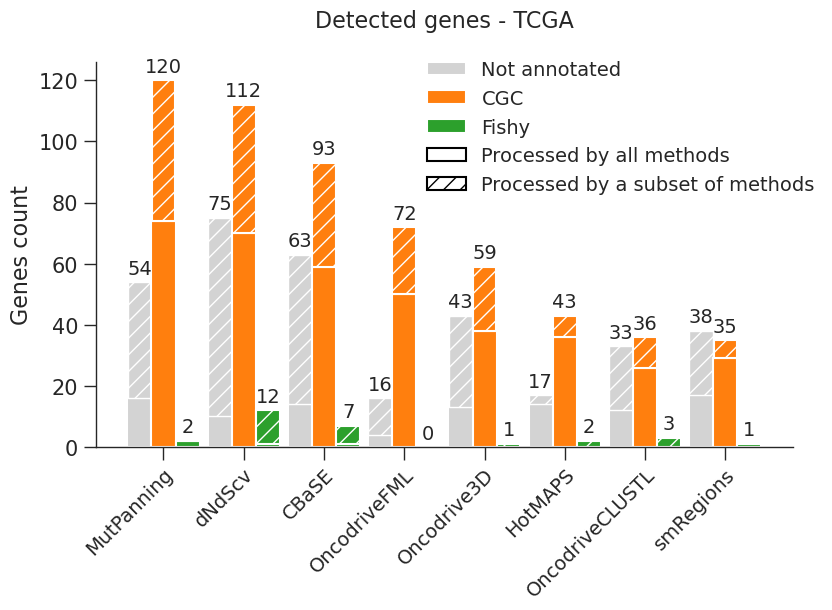

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.21it/s]


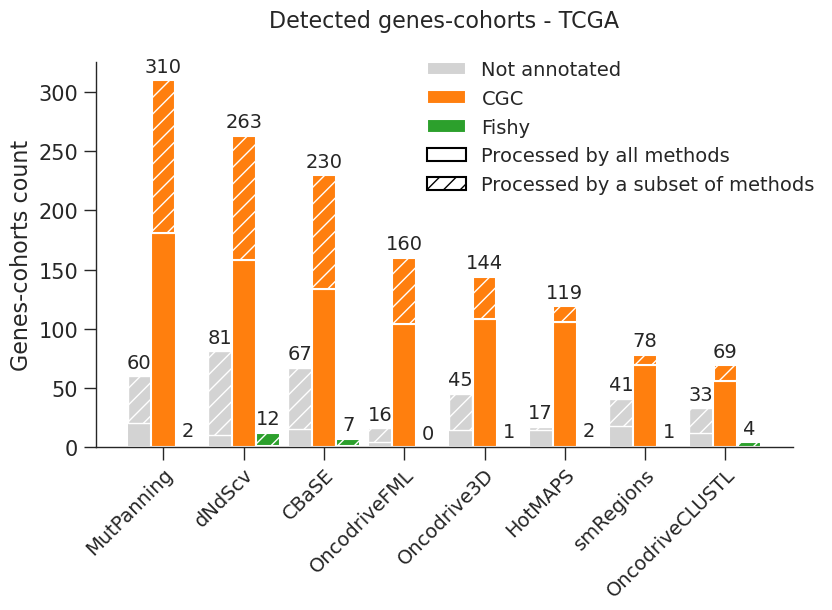

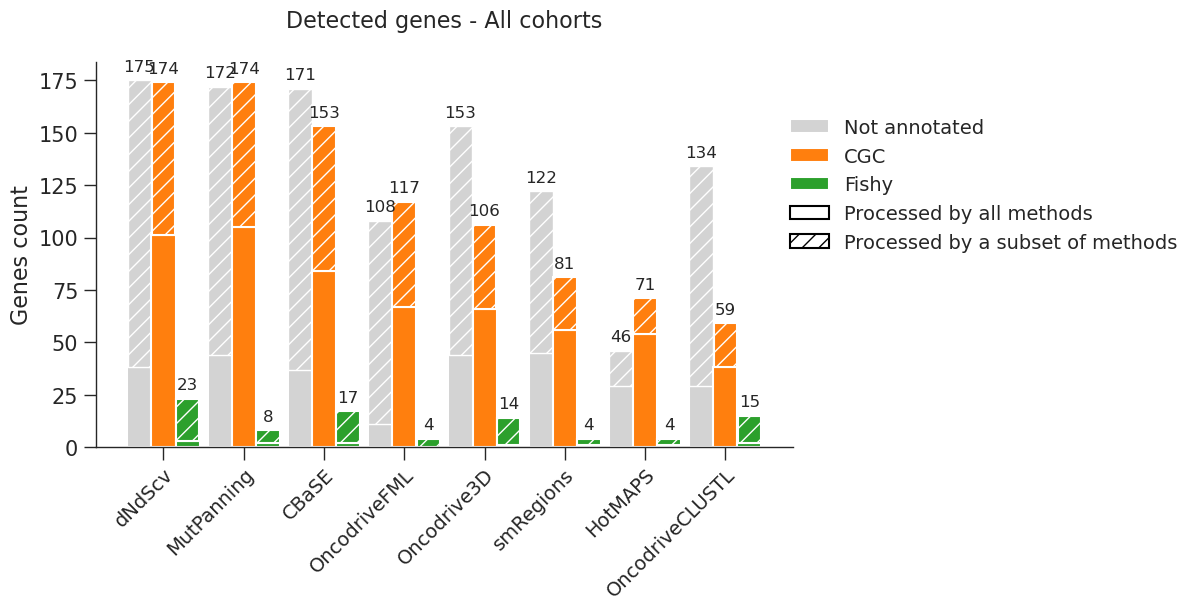

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:43<00:00,  4.91it/s]


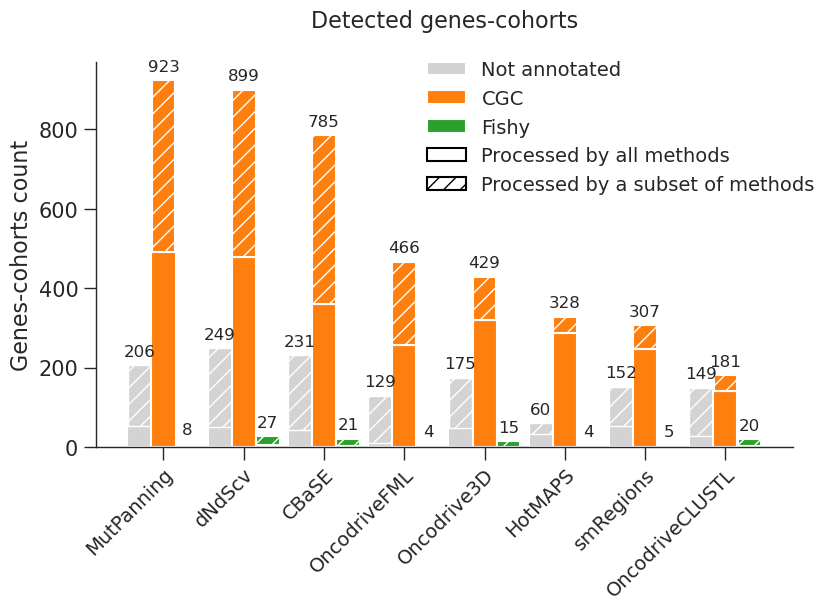

In [15]:
# TCGA - Unique genes
plot_hits_barplot(genetable_subset, lst_methods, names_dic, unique=True, title="Detected genes - TCGA\n", 
                  fontsize_annotation=14,
                  filename="plots/number_detected/hits_stacked_barplot_tcga_unique")

# TCGA - All genes
plot_hits_barplot(genetable_subset, lst_methods, names_dic, 
                  title="Detected genes-cohorts - TCGA\n",
                  fontsize_annotation=14,
                  filename="plots/number_detected/hits_stacked_barplot_tcga")

# All cohorts - Unique genes
plot_hits_barplot(genetable, lst_methods, names_dic, unique=True,
                  fontsize_annotation=11,
                  title="Detected genes - All cohorts\n", legend_box=(0.97, 0.9),
                  filename="plots/number_detected/hits_stacked_barplot_unique")

# All cohorts - All genes
plot_hits_barplot(genetable, lst_methods, names_dic, vspace_annotation=50, 
                  fontsize_annotation=11,
                  title="Detected genes-cohorts\n", 
                  filename="plots/number_detected/hits_stacked_barplot")

In [91]:
# I can provide an extra arg df genes_to_skip_df or something like that
# I can use this df such that, for each method, we look at the genes already 
# detected and we filter them out from the new sum so that we don't count them twice

# A gene could be processed by all genes in one cohort and processed by a subset of genes in other cohorts, we don't want to count it twice 


def get_unique_hits(df, qval_lst_name, df_to_exclude=None):
    
    # Initialize a dictionary to store the sums
    sums_by_method = {}

    # Iterate through each q-value column
    for column in qval_lst_name:
        # Filter rows where the p-value is lower than 0.01 and drop duplicates in the 'Gene' column
        method_df = df[df[column] < 0.01].drop_duplicates(subset='Gene')

        # Remove genes that are already counted to avoid counting them twice
        if df_to_exclude is not None:
            method_genes_to_exclude = df_to_exclude[df_to_exclude[column] < 0.01].Gene.unique()
            ix_filter = ~method_df.Gene.isin(method_genes_to_exclude)
            method_df = method_df[ix_filter]

        # Store the sum in the dictionary with the method name as the key
        sums_by_method[column] = len(method_df)
        
    return pd.DataFrame(sums_by_method, index=[0])
    

def get_hits_summary(cohort_df, 
                     lst_name, 
                     alpha = 0.01, 
                     unknown = True, 
                     unique = False, 
                     df_to_exclude = None):
    """
    Get the count of significant genes for each method 
    for both p-values and q-values, all genes and CGC genes.
    """

    # Get qvals hits, CGC, and Fishy count
    
    qval_lst_name = [f"{name}_qval" for name in lst_name]
    
    if unique:
        cohort_hits_cgc = cohort_df[(cohort_df["CGC"] == 1)]
        qval_hits_cgc = get_unique_hits(cohort_hits_cgc, qval_lst_name, df_to_exclude)
        qval_hits_cgc.columns = [f"{col}_cgc" for col in qval_hits_cgc.columns]

        cohort_hits_fish = cohort_df[(cohort_df["Fish"] == 1)]
        qval_hits_fish = get_unique_hits(cohort_hits_fish, qval_lst_name, df_to_exclude)
        qval_hits_fish.columns = [f"{col}_fish" for col in qval_hits_fish.columns]

        df_to_exclude = pd.concat((df_to_exclude, cohort_hits_fish))
        if unknown:
            cohort_df_no_annot = cohort_df[(cohort_df["CGC"] == 0) & (cohort_df["Fish"] == 0)]
            qval_hits = get_unique_hits(cohort_df_no_annot, qval_lst_name, df_to_exclude)
        else:
            qval_hits = get_unique_hits(cohort_df, qval_lst_name, df_to_exclude)
        
        return pd.concat((qval_hits, qval_hits_cgc, qval_hits_fish), axis=1)
    
    else:
        if unknown:
            cohort_df_no_annot = cohort_df[(cohort_df["CGC"] == 0) & (cohort_df["Fish"] == 0)]
            qval_hits = cohort_df_no_annot[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: x < alpha).sum()
        else:
            qval_hits = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: x < alpha).sum()
        qval_hits_cgc = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: cohort_df.loc[x < alpha, "CGC"]).sum()
        qval_hits_cgc.index = [f"{i}_cgc" for i in qval_hits_cgc.index]
        qval_hits_fish = cohort_df[[s for s in qval_lst_name if s in cohort_df.columns]].apply(lambda x: cohort_df.loc[x < alpha, "Fish"]).sum()
        qval_hits_fish.index = [f"{i}_fish" for i in qval_hits_fish.index]
        
        return pd.DataFrame(pd.concat((qval_hits, qval_hits_cgc, qval_hits_fish))).T


def get_hits_summary_lst_cohorts(genetable,
                                 lst_name,
                                 overlaps_all = False,
                                 alpha = 0.01,
                                 unknown = True,
                                 unique = False,
                                 df_to_exclude = None):
    """
    Get count of significant genes (pvals and qvals) and 
    count and ratio of significant genes in CGC across 
    each method and all provided cohorts.
    """
    
    # Get sum of unique genes across all cohorts
    if unique:
        hits_df = get_hits_summary(genetable, lst_name, alpha = alpha, unknown = unknown, unique = True, df_to_exclude = df_to_exclude)
        hits_df.insert(0, "Cohort", "All_cohorts")
        
        return hits_df
    
    # Get sum of genes-cohorts
    else:
        lst_cohort_result = []
        for cohort in tqdm(genetable.Cohort.unique()):

            table_df = genetable[genetable["Cohort"] == cohort]

            if len(table_df) > 0:

                # Get hits summary table
                hits_df = get_hits_summary(table_df, lst_name, alpha = alpha, unknown = unknown, unique = False)
                hits_df.insert(0, "Cohort", cohort)
                lst_cohort_result.append(hits_df)
        
        if len(lst_cohort_result) > 0:
            return pd.concat(lst_cohort_result).reset_index(drop=True)


def get_sum_by_annotation(hits_df, lst_name, unknown=True):

    df = hits_df.copy()
    cols = [f"{name}_qval" for name in lst_name]
    cols_cgc = [f"{name}_qval_cgc" for name in lst_name]
    cols_fish = [f"{name}_qval_fish" for name in lst_name]
        
    df_sum = pd.DataFrame(df[cols].sum()).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    if unknown:
        df_sum["Gene"] = "Not annotated"
    else:
        df_sum["Gene"] = "Any"
    
    df_sum_cgc = df[cols_cgc].sum()
    df_sum_cgc.index = cols
    df_sum_cgc = pd.DataFrame(df_sum_cgc).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    df_sum_cgc["Gene"] = "CGC"

    df_sum_fish = df[cols_fish].sum()
    df_sum_fish.index = cols
    df_sum_fish = pd.DataFrame(df_sum_fish).reset_index().rename(columns = {"index" : "Method", 0 : "Count"})
    df_sum_fish["Gene"] = "Fish"

    df_sum = pd.concat((df_sum, df_sum_cgc, df_sum_fish))
    
    return df_sum


def plot_hits_barplot(genetable_df, lst_name, dict_name, 
                      figsize=(9,5), 
                      sort=True, 
                      legend_box=(0.45, 1.05),
                      unknown=True,
                      vspace_annotation=18,
                      title=None,
                      unique=False,
                      filename="hits_stacked_barplot.png"):

    genetable = genetable_df.copy()
    cols = [f"{name}_qval" for name in lst_name]
    cols_cgc = [f"{name}_qval_cgc" for name in lst_name]
    cols_fish = [f"{name}_qval_fish" for name in lst_name]

    # Get sum df
    pval_cols = [f"{col}_pval" for col in lst_methods]
    genetable_overlap = genetable.dropna(subset=[f"{col}_pval" for col in lst_methods])
    genetable_no_overlap = genetable[genetable[pval_cols].isna().any(axis=1)]
    
    hits_df_overlap = get_hits_summary_lst_cohorts(genetable_overlap, 
                                                   lst_methods, 
                                                   unknown=unknown, 
                                                   unique=unique)
    hits_df_no_overlap = get_hits_summary_lst_cohorts(genetable_no_overlap, 
                                                      lst_methods, 
                                                      unknown=unknown, 
                                                      unique=unique, 
                                                      df_to_exclude=genetable_overlap if unique else None)
    
    df_sum_overlap = get_sum_by_annotation(hits_df_overlap, lst_methods, unknown=unknown)
    df_sum_no_overlap = get_sum_by_annotation(hits_df_no_overlap, lst_methods, unknown=unknown)
    df_sum_overlap["Overlap"] = "Yes"
    df_sum_no_overlap["Overlap"] = "No"

    df_sum = pd.concat((df_sum_overlap, df_sum_no_overlap)).reset_index(drop=True)    
        
    # Get counts by annotation and overlap for each method
    if unknown:
        unknown_annotation = "Not annotated"
    else:
        unknown_annotation = "Any"
    if sort:
        lst_name = list(df_sum[df_sum["Gene"] == "CGC"].groupby("Method").sum().sort_values(by=["Count"], ascending=False).index)
    cgc = np.array([get_count(df_sum, method, annotation="CGC", overlap="Yes") for method in lst_name])
    cgc_no_overlap = np.array([get_count(df_sum, method, annotation="CGC", overlap="No") for method in lst_name])
    fish = np.array([get_count(df_sum, method, annotation="Fish", overlap="Yes") for method in lst_name])
    fish_no_overlap = np.array([get_count(df_sum, method, annotation="Fish", overlap="No") for method in lst_name])
    unknown = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="Yes") for method in lst_name])
    unknown_no_overlap = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="No") for method in lst_name])

    barplot_hits_stacked_dodge(unknown, unknown_no_overlap,
                               cgc, cgc_no_overlap,
                               fish, fish_no_overlap,
                               lst_name,
                               dict_name,
                               unknown_annotation,
                               figsize=figsize,
                               legend_box=legend_box,
                               vspace_annotation=vspace_annotation,
                               title=title,
                               unique=unique,
                               filename=filename)


def barplot_hits_stacked_dodge(unknown, unknown_no_overlap,
                               cgc, cgc_no_overlap,
                               fish, fish_no_overlap,
                               lst_name,
                               dict_name,
                               unknown_annotation="Not annotated",
                               figsize=(12,6),
                               legend_box=(0.45, 1.05),
                               vspace_annotation=18,
                               title=None,
                               unique=False,
                               filename="hits_stacked_barplot.png"):

    lst_all_values = unknown, unknown_no_overlap, cgc, cgc_no_overlap, fish, fish_no_overlap
    n_methods = len(unknown)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=figsize)
    with sns.axes_style("white"):
        sns.set_context("talk")   
        sns.set_style("ticks")

        # Plot details
        bar_width = 0.3
        epsilon = .005
        line_width = 1
        unknown_bar_positions = np.arange(len(unknown))
        cgc_bar_positions = unknown_bar_positions + bar_width
        fish_bar_positions = cgc_bar_positions + bar_width

        # Bar plots
        ax = plt.gca()
        unknown_bar = plt.bar(unknown_bar_positions, unknown, bar_width,
                              color="lightgray",
                              label=unknown_annotation)
        unknown_bar = plt.bar(unknown_bar_positions, unknown_no_overlap, bar_width-epsilon,
                              bottom=unknown,
                              color="lightgray",
                              edgecolor='white',
                              linewidth=line_width,
                              hatch='//')

        cgc_bar = plt.bar(cgc_bar_positions, cgc, bar_width,
                               color=colors[1],
                               label='CGC')
        cgc_bar = plt.bar(cgc_bar_positions, cgc_no_overlap, bar_width-epsilon,
                               bottom=cgc,
                               color=colors[1],
                               hatch='//',
                               edgecolor='white',
                               linewidth=line_width+0.5)

        fish_bar = plt.bar(fish_bar_positions, fish, bar_width,
                               color=colors[2],
                               label='Fishy')
        fish_bar = plt.bar(fish_bar_positions, fish_no_overlap, bar_width-epsilon,
                               bottom=fish,
                               color=colors[2],
                               hatch='//',
                               edgecolor='white',
                               linewidth=line_width+0.5)

        # Add annotations on top of each bar
        up = 1, 3, 5, 7
        down = 0, 2, 4, 6 
        max_sum_bar = 0

        for i, p in enumerate(ax.patches):

            method_ix = i%n_methods
            label_ix = int(i / n_methods)

            if label_ix%2 > 0:
                n=-1
            else:
                n=1

            sum_bar = lst_all_values[label_ix][method_ix] + lst_all_values[label_ix+n][method_ix]

            if label_ix in up:
                pass
                #sum_bar += vspace_annotation
            else:
                continue

            if sum_bar > max_sum_bar:
                max_sum_bar = sum_bar

            ax.annotate(format(sum_bar, '.0f'),                
                        (p.get_x() + p.get_width() / 2., sum_bar),
                        ha = 'center', va = 'center',
                        xytext = (0, 10),
                        textcoords = 'offset points',
                        fontsize=10)

        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(facecolor='white', edgecolor='black', label='Processed by all methods'))
        handles.append(mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label="Processed by a subset of methods"))

        if unique:
            plt.ylabel("Unique genes count", fontsize = 16)
        else:
            plt.ylabel("Genes-cohorts count", fontsize = 16)

        plt.yticks(fontsize=15)      
        plt.xticks((unknown_bar_positions+cgc_bar_positions+fish_bar_positions)/3, 
                   [dict_name[name.split("_")[0]] for name in lst_name], 
                   rotation=45, 
                   fontsize=14,
                   rotation_mode="anchor", 
                   ha='right')
        plt.legend(handles=handles, bbox_to_anchor=legend_box, fontsize=14, frameon=False)
        plt.title(title, fontsize=16)
        sns.despine()
        ax.spines['left'].set_linewidth(1) 
        ax.spines['bottom'].set_linewidth(1) 
        ax.tick_params(axis='both', which='both', width=1)
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

##### Better but numbers on all cohorts still don't match

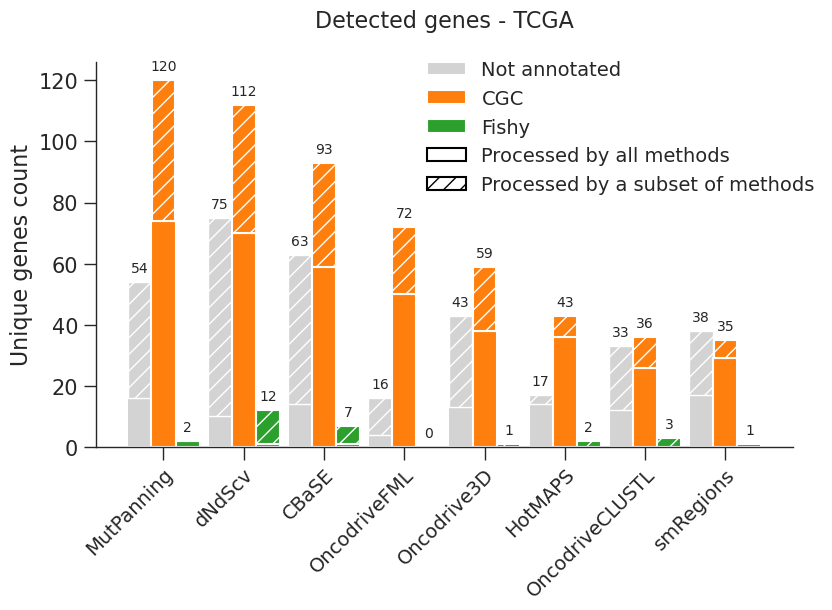

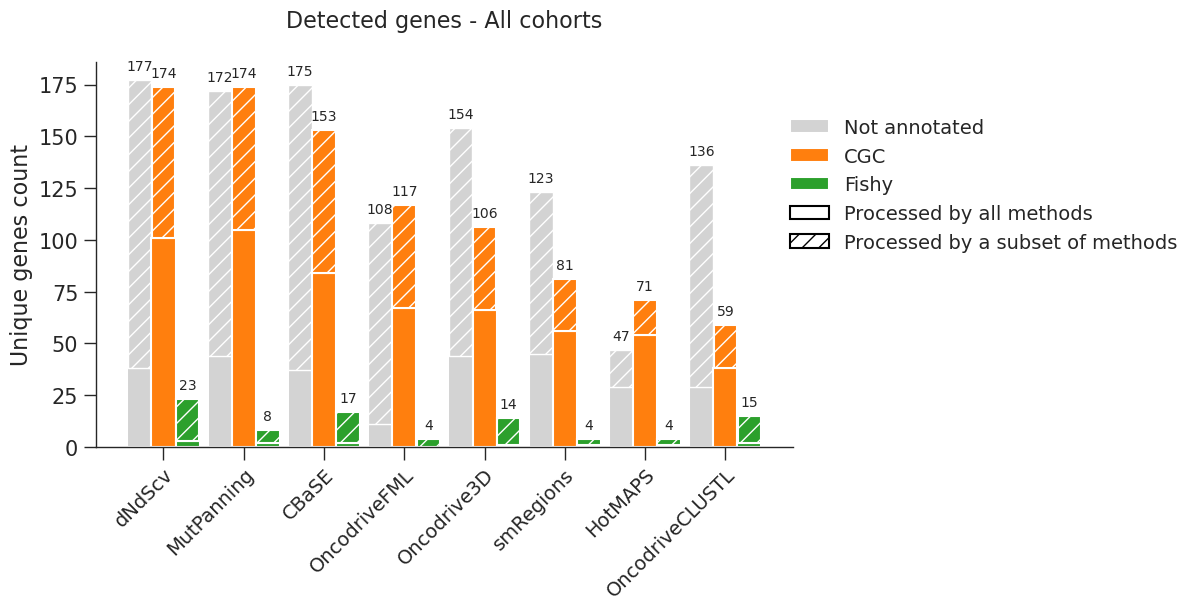

In [48]:
# TCGA - Unique genes
plot_hits_barplot(genetable_subset, lst_methods, names_dic, unique=True, title="Detected genes - TCGA\n")

# All cohorts - Unique genes
plot_hits_barplot(genetable, lst_methods, names_dic, unique=True,
                  title="Detected genes - All cohorts\n", legend_box=(0.97, 0.9))

In [70]:
not_annot_asd = genetable[(genetable["o3d_qval"] < 0.01) & (genetable["CGC"] == 0) & (genetable["Fish"] == 0)].Gene.unique()
cgc_asd = genetable[(genetable["o3d_qval"] < 0.01) & (genetable["CGC"] == 1)].Gene.unique()
fish_asd = genetable[(genetable["o3d_qval"] < 0.01) & (genetable["Fish"] == 1)].Gene.unique()

In [81]:
len(genetable[genetable["o3d_qval"] < 0.01].Gene.unique())

273

In [84]:
len(genetable[(genetable["o3d_qval"] < 0.01) & (genetable["CGC"] == 0) & (genetable["Fish"] == 0)].Gene.unique())

154

In [88]:
[gene for gene in fish_asd if gene in not_annot_asd]

['OR5H14']

In [86]:
len(fish_asd)

14

In [77]:
cgc_asd

array(['PIK3CA', 'FGFR3', 'FBXW7', 'TP53', 'BRAF', 'NRAS', 'CTNNA2',
       'PPP6C', 'CTNNB1', 'KRAS', 'SMAD4', 'PCBP1', 'ERBB2', 'BCL9L',
       'ERBB3', 'EGFR', 'SPOP', 'KIT', 'SF3B1', 'XPO1', 'MYD88', 'MED12',
       'IKZF3', 'IRF4', 'ALK', 'U2AF1', 'MAP2K1', 'IDH1', 'RAC1',
       'KNSTRN', 'CRNKL1', 'EZH2', 'HRAS', 'CD79B', 'ESR1', 'AKT1',
       'FOXA1', 'NOTCH2', 'PTEN', 'NFE2L2', 'PPP2R1A', 'BCOR', 'HLA-A',
       'BAP1', 'VHL', 'CDKN2A', 'KDR', 'PLCG1', 'AR', 'ERBB4', 'NSD2',
       'PTPN11', 'MYCN', 'ASPM', 'FOXO1', 'ID3', 'MAX', 'RPL10', 'USP8',
       'IKBKB', 'CCND1', 'ARHGAP5', 'STAT3', 'CREBBP', 'SGK1', 'SMO',
       'SMARCA4', 'KMT2D', 'SIRPA', 'KDM6A', 'STAT6', 'DNMT3A', 'SRSF2',
       'KMT2C', 'IDH2', 'BCLAF1', 'FLT3', 'RUNX1', 'GATA2', 'JAK2',
       'FAM47C', 'CDK4', 'BMP5', 'GNAS', 'CIC', 'ACVR1', 'PIK3R1',
       'DGCR8', 'NOTCH1', 'KIF5B', 'MAPK1', 'MAP3K1', 'MTOR', 'SETD2',
       'ERCC2', 'GNAQ', 'GNA11', 'FGFR2', 'DICER1', 'CHD4', 'CTCF',
       'KAT6A', 'RHO

In [66]:
fish_asd = genetable[(genetable["o3d_qval"] < 0.01) & (genetable["Fish"] == 1)].Gene.unique()

14

In [ ]:
genetable[genetable[""]]

In [67]:
len(genetable[genetable["o3d_qval"] < 0.01].Gene.unique())

273

In [55]:
len(genetable[(genetable["o3d_qval"] < 0.01) & (genetable["CGC"] == 1)].Gene.unique())

106

##### Everything ok except Barplot below unique genes TCGA (+1 count on O3D and OCLUSTL)

In [150]:
cgc_o3d = genetable_subset[(genetable_subset["o3d_qval"] < 0.01) & (genetable_subset["CGC"] == 1)]
cgc_o3d

Gene  Uniprot_ID o3d_status  CGC  Fish  o3d_rank  o3d_pval  \
3062778  NFE2L2      Q16236  Processed    1     0       0.0       0.0   
3062779    TP53      K7PPA8  Processed    1     0       1.0       0.0   
3062780  PIK3CA      P42336  Processed    1     0       2.0       0.0   
3062781  CDKN2A      K7PML8  Processed    1     0       3.0       0.0   
3062782    HRAS      P01112  Processed    1     0       4.0       0.0   
...         ...         ...        ...  ...   ...       ...       ...   
4496308   MED12      Q93074  Processed    1     0       2.0       0.0   
4496309  CTNNB1  A0A024R2Q3  Processed    1     0       3.0       0.0   
4539226    TP53      K7PPA8  Processed    1     0       0.0       0.0   
4560686    HRAS      P01112  Processed    1     0       0.0       0.0   
4560687   EPAS1      Q99814  Processed    1     0       1.0       0.0   

         o3d_qval  cbase_rank    cbase_pval  ...   clustl_pval   clustl_qval  \
3062778       0.0         6.0  0.000000e+00  ...  2.892341e-03  3.805247e-01   
3062779       0.0        11.0  0.000000e+00  ...  5.538100e-05  7.397056e-02   
3062780       0.0        53.0  3.878710e-04  ...  3.725978e-06  7.464997e-03   
3062781       0.0         5.0  0.000000e+00  ...  3.985347e-04  2.661548e-01   
3062782       0.0       990.0  3.366977e-02  ...  3.379845e-03  3.805247e-01   
...           ...         ...           ...  ...           ...           ...   
4496308       0.0       527.0  1.968070e-02  ...  1.510466e-01  2.966402e-01   
4496309       0.0        41.0  5.759134e-04  ...  1.463592e-01  2.966402e-01   
4539226       0.0         0.0  0.000000e+00  ...  4.686066e-02  1.594146e-01   
4560686       0.0         0.0  0.000000e+00  ...  3.918919e-12  7.837837e-11   
4560687       0.0         4.0  5.357334e-07  ...  6.175450e-03  4.116967e-02   

         fml_rank  fml_pval  fml_qval  smreg_rank    smreg_pval    smreg_qval  \
3062778       3.0  0.000001  0.001441         NaN           NaN           NaN   
3062779       1.0  0.000001  0.001441         0.0  9.534979e-56  1.202361e-51   
3062780      29.0  0.000310  0.148955         1.0  8.013395e-12  5.052445e-08   
3062781       5.0  0.000001  0.001441         NaN           NaN           NaN   
3062782    2313.0  0.129510  0.927878      2046.0  1.413890e-01  7.547557e-01   
...           ...       ...       ...         ...           ...           ...   
4496308    1828.0  0.175240  0.902341         NaN           NaN           NaN   
4496309     400.0  0.040470  0.823022         NaN           NaN           NaN   
4539226       0.0  0.000001  0.001122         0.0  3.952689e-11  4.454681e-08   
4560686      61.0  0.036610  0.601014         2.0  2.344160e-02  5.079014e-02   
4560687       5.0  0.002260  0.445220         0.0  5.101237e-13  6.631608e-12   

              Cancer         Cohort  
3062778         LUSC  TCGA_WXS_LUSC  
3062779         LUSC  TCGA_WXS_LUSC  
3062780         LUSC  TCGA_WXS_LUSC  
3062781         LUSC  TCGA_WXS_LUSC  
3062782         LUSC  TCGA_WXS_LUSC  
...              ...            ...  
4496308         PRAD  TCGA_WXS_PRAD  
4496309         PRAD  TCGA_WXS_PRAD  
4539226  SOFT_TISSUE  TCGA_WXS_SARC  
4560686         PGNG  TCGA_WXS_PGNG  
4560687         PGNG  TCGA_WXS_PGNG  

[144 rows x 31 columns]

In [169]:
len(cgc_o3d.Gene.unique())

59

In [171]:
gene_proc = cgc_o3d.dropna(subset=[f"{col}_pval" for col in lst_methods])

In [172]:
gene_notproc = cgc_o3d[cgc_o3d[pval_cols].isna().any(axis=1)]

In [173]:
len(gene_proc.Gene.unique())

38

In [174]:
len(gene_notproc.Gene.unique())

22

In [176]:
ix_filter = ~gene_notproc.Gene.isin(gene_proc.Gene.unique())
len(gene_notproc[ix_filter].Gene.unique())

21

In [178]:
len(gene_proc.Gene.unique())

38

In [226]:
lst_name = lst_methods 
dict_name = names_dic
figsize=(9,5)
sort=True
legend_box=(0.45, 1.05)
unknown=False
vspace_annotation=18
title=None
unique=True
filename=None

genetable = genetable_subset.copy()
cols = [f"{name}_qval" for name in lst_name]
cols_cgc = [f"{name}_qval_cgc" for name in lst_name]
cols_fish = [f"{name}_qval_fish" for name in lst_name]

In [227]:
hits_df_overlap = get_hits_summary_lst_cohorts(genetable_overlap, lst_methods, unknown=unknown, unique=unique)
hits_df_overlap

0
Filtering o3d_qval
0
0


Cohort  o3d_qval  hotmaps_qval  clustl_qval  smreg_qval  cbase_qval  \
0  All_cohorts        51            50           38          47          74   

   dndscv_qval  mutpan_qval  fml_qval  o3d_qval_cgc  ...  mutpan_qval_cgc  \
0           81           92        54            38  ...               74   

   fml_qval_cgc  o3d_qval_fish  hotmaps_qval_fish  clustl_qval_fish  \
0            50              0                  0                 0   

   smreg_qval_fish  cbase_qval_fish  dndscv_qval_fish  mutpan_qval_fish  \
0                0                0                 0                 0   

   fml_qval_fish  
0              0  

[1 rows x 25 columns]

In [230]:
# Get sum df
pval_cols = [f"{col}_pval" for col in lst_methods]
genetable_overlap = genetable.dropna(subset=[f"{col}_pval" for col in lst_methods])
genetable_no_overlap = genetable[genetable[pval_cols].isna().any(axis=1)]

# if unique:
#     ix_filter = ~genetable_no_overlap.Gene.isin(genetable_overlap.Gene.unique())
#     genetable_no_overlap = genetable_no_overlap[ix_filter]

hits_df_overlap = get_hits_summary_lst_cohorts(genetable_overlap, lst_methods, unknown=unknown, unique=unique)
hits_df_no_overlap = get_hits_summary_lst_cohorts(genetable_no_overlap, lst_methods, unknown=unknown, unique=unique)
# df_sum_overlap = get_sum_by_annotation(hits_df_overlap, lst_methods, unknown=unknown)
# df_sum_no_overlap = get_sum_by_annotation(hits_df_no_overlap, lst_methods, unknown=unknown)

0
Filtering o3d_qval
0
0
1
Filtering o3d_qval
1
1


In [233]:
hits_df_no_overlap

Cohort  o3d_qval  hotmaps_qval  clustl_qval  smreg_qval  cbase_qval  \
0  All_cohorts        53            12           35          27         106   

   dndscv_qval  mutpan_qval  fml_qval  o3d_qval_cgc  ...  mutpan_qval_cgc  \
0          136          103        44            22  ...               65   

   fml_qval_cgc  o3d_qval_fish  hotmaps_qval_fish  clustl_qval_fish  \
0            32              1                  2                 2   

   smreg_qval_fish  cbase_qval_fish  dndscv_qval_fish  mutpan_qval_fish  \
0                0                6                 9                 0   

   fml_qval_fish  
0              0  

[1 rows x 25 columns]

In [234]:
hits_df_no_overlap = get_hits_summary_lst_cohorts(genetable_no_overlap, 
                                                  lst_methods, 
                                                  unknown=unknown, 
                                                  unique=unique, 
                                                  df_to_exclude=genetable_no_overlap)

53
Filtering o3d_qval
30
41
22
Filtering o3d_qval
22
13
1
Filtering o3d_qval
1
1


In [235]:
hits_df_no_overlap

Cohort  o3d_qval  hotmaps_qval  clustl_qval  smreg_qval  cbase_qval  \
0  All_cohorts        41             6           24          19          52   

   dndscv_qval  mutpan_qval  fml_qval  o3d_qval_cgc  ...  mutpan_qval_cgc  \
0           71           50        22            13  ...               23   

   fml_qval_cgc  o3d_qval_fish  hotmaps_qval_fish  clustl_qval_fish  \
0            12              1                  2                 2   

   smreg_qval_fish  cbase_qval_fish  dndscv_qval_fish  mutpan_qval_fish  \
0                0                6                 9                 0   

   fml_qval_fish  
0              0  

[1 rows x 25 columns]

In [ ]:
genetable
lst_name
overlaps_all = False
alpha = 0.01
unknown = True
unique = False
df_to_exclude = None

hits_df = get_hits_summary(genetable, lst_name, alpha = alpha, unknown = unknown, unique = True, df_to_exclude = df_to_exclude)
hits_df.insert(0, "Cohort", "All_cohorts")

In [238]:
get_hits_summary(genetable_no_overlap, lst_methods, alpha = 0.01, unknown = False, unique = True, df_to_exclude = genetable_overlap)

53
Filtering o3d_qval
13
41
22
Filtering o3d_qval
38
13
1
Filtering o3d_qval
1
1


o3d_qval  hotmaps_qval  clustl_qval  smreg_qval  cbase_qval  dndscv_qval  \
0        41             6           24          19          52           71   

   mutpan_qval  fml_qval  o3d_qval_cgc  hotmaps_qval_cgc  ...  \
0           50        22            13                 3  ...   

   mutpan_qval_cgc  fml_qval_cgc  o3d_qval_fish  hotmaps_qval_fish  \
0               23            12              1                  2   

   clustl_qval_fish  smreg_qval_fish  cbase_qval_fish  dndscv_qval_fish  \
0                 2                0                6                 9   

   mutpan_qval_fish  fml_qval_fish  
0                 0              0  

[1 rows x 24 columns]

In [242]:
cohort_df = genetable_no_overlap
df_to_exclude = genetable_overlap

lst_name = lst_methods 
qval_lst_name = [f"{name}_qval" for name in lst_name]



df_to_exclude_cgc = df_to_exclude[df_to_exclude["CGC"] == 1] if isinstance(df_to_exclude, pd.DataFrame) else None
cohort_hits_cgc = cohort_df[(cohort_df["CGC"] == 1)]
qval_hits_cgc = get_unique_hits(cohort_hits_cgc, qval_lst_name, df_to_exclude_cgc)
qval_hits_cgc.columns = [f"{col}_cgc" for col in qval_hits_cgc.columns]
qval_hits_cgc

22
Filtering o3d_qval
38
13


o3d_qval_cgc  hotmaps_qval_cgc  clustl_qval_cgc  smreg_qval_cgc  \
0            13                 3                5               2   

   cbase_qval_cgc  dndscv_qval_cgc  mutpan_qval_cgc  fml_qval_cgc  
0              16               22               23            12

In [250]:
method_df = df[df['o3d_qval'] < 0.01].drop_duplicates(subset='Gene')
len(method_df)

22

In [254]:
method_genes_to_exclude = df_to_exclude[df_to_exclude["o3d_qval"] < 0.01].Gene.unique()
method_genes_to_exclude

array(['TP53', 'PIK3CA', 'HRAS', 'BRAF', 'NRAS', 'MAP2K1', 'RAC1', 'IDH1',
       'CDK4', 'KIT', 'KRAS', 'GNAS', 'SMAD4', 'CIC', 'IDH2', 'EGFR',
       'PIK3R1', 'FBXW7', 'NOTCH1', 'KIF5B', 'CTNNB1', 'ERBB2', 'AKT1',
       'FOXA1', 'MAP3K1', 'VHL', 'MTOR', 'CREBBP', 'ERCC2', 'PPP2R1A',
       'GNAQ', 'GNA11', 'DICER1', 'ERBB3', 'SPOP', 'RHOA', 'CNBD1',
       'CDH1'], dtype=object)

In [ ]:
ix_filter = ~method_df.Gene.isin(genetable_overlap.Gene.unique())

In [247]:
df = cohort_hits_cgc
df_to_exclude = df_to_exclude_cgc


# Initialize a dictionary to store the sums
sums_by_method = {}

# Iterate through each q-value column
for column in qval_lst_name:
    # Filter rows where the q-value is lower than 0.01 and drop duplicates in the 'Gene' column
    method_df = df[df[column] < 0.01].drop_duplicates(subset='Gene')

    # Remove genes that are already counted to avoid counting them twice
    if df_to_exclude is not None:

        if column == "o3d_qval":
            print(len(method_df))
            
        method_genes_to_exclude = df_to_exclude[df_to_exclude[column] < 0.01].Gene.unique()
        ix_filter = ~method_df.Gene.isin(method_genes_to_exclude.Gene.unique())
        method_df = method_df[ix_filter]

        if column == "o3d_qval":
            print("Filtering", column)
            print(len(method_genes_to_exclude))
            print(len(method_df))

    # Store the sum in the dictionary with the method name as the key
    sums_by_method[column] = len(method_df)
    
pd.DataFrame(sums_by_method, index=[0])

22
Filtering o3d_qval
38
13


o3d_qval  hotmaps_qval  clustl_qval  smreg_qval  cbase_qval  dndscv_qval  \
0        13             3            5           2          16           22   

   mutpan_qval  fml_qval  
0           23        12

In [ ]:
# Il problema è che questo funziona bene se guardiamo ad ogni singolo metodo
# Invece così come lo sto facendo, rimuoviamo qualsiasi gene tra i non processati da ogni metodo che è stato processato da almeno un metodo
# Va fatto per ogni metodo

In [ ]:

# Get sum df
pval_cols = [f"{col}_pval" for col in lst_methods]
genetable_overlap = genetable.dropna(subset=[f"{col}_pval" for col in lst_methods])
genetable_no_overlap = genetable[genetable[pval_cols].isna().any(axis=1)]
hits_df_overlap = get_hits_summary_lst_cohorts(genetable_overlap, lst_methods, unknown=unknown, unique=unique)
hits_df_no_overlap = get_hits_summary_lst_cohorts(genetable_no_overlap, lst_methods, unknown=unknown, unique=unique)

df_sum_overlap = get_sum_by_annotation(hits_df_overlap, lst_methods, unknown=unknown)
df_sum_no_overlap = get_sum_by_annotation(hits_df_no_overlap, lst_methods, unknown=unknown)
df_sum_overlap["Overlap"] = "Yes"
df_sum_no_overlap["Overlap"] = "No"

df_sum = pd.concat((df_sum_overlap, df_sum_no_overlap)).reset_index(drop=True)    
    
# Get counts by annotation and overlap for each method
if unknown:
    unknown_annotation = "Not annotated"
else:
    unknown_annotation = "Any"
if sort:
    lst_name = list(df_sum[df_sum["Gene"] == "CGC"].groupby("Method").sum().sort_values(by=["Count"], ascending=False).index)
cgc = np.array([get_count(df_sum, method, annotation="CGC", overlap="Yes") for method in lst_name])
cgc_no_overlap = np.array([get_count(df_sum, method, annotation="CGC", overlap="No") for method in lst_name])
fish = np.array([get_count(df_sum, method, annotation="Fish", overlap="Yes") for method in lst_name])
fish_no_overlap = np.array([get_count(df_sum, method, annotation="Fish", overlap="No") for method in lst_name])
unknown = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="Yes") for method in lst_name])
unknown_no_overlap = np.array([get_count(df_sum, method, annotation=unknown_annotation, overlap="No") for method in lst_name])

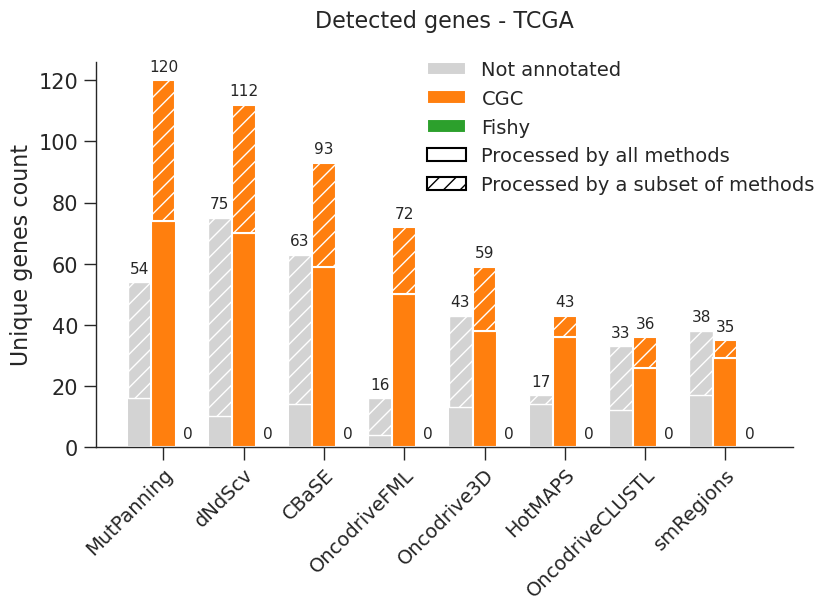

In [19]:
# TCGA - Unique genes
plot_hits_barplot(genetable_subset, lst_methods, names_dic, 
                  unique=True,
                  title="Detected genes - TCGA\n")

# All cohorts - Unique genes
plot_hits_barplot(genetable, lst_methods, names_dic, 
                  unique=True,
                  title=None,
                  legend_box=(0.45, 0.9))

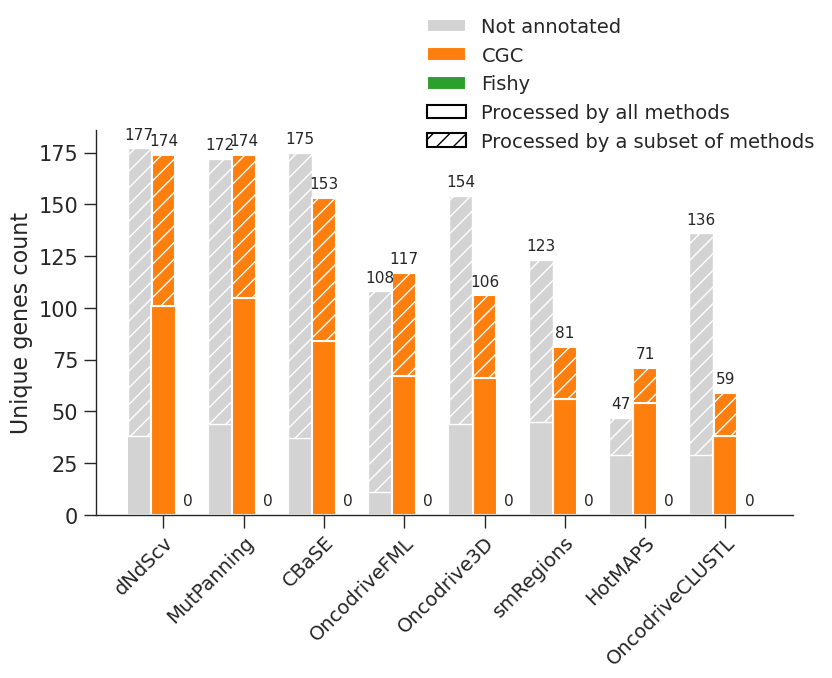

In [26]:
# All cohorts - Unique genes
plot_hits_barplot(genetable, lst_methods, names_dic, 
                  unique=True,
                  title=None,
                  legend_box=(0.45, 0.9))

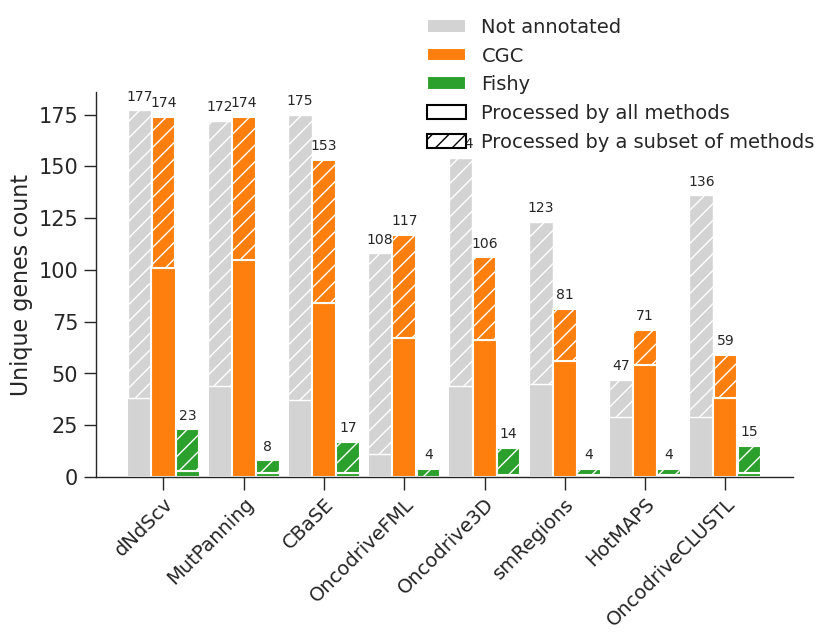

In [44]:
# All cohorts - Unique genes

plot_hits_barplot(genetable, lst_methods, names_dic, 
                  unique=True,
                  title=None,
                  legend_box=(0.45, 0.8))

## Number by cohort

### TCGA

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.94it/s]


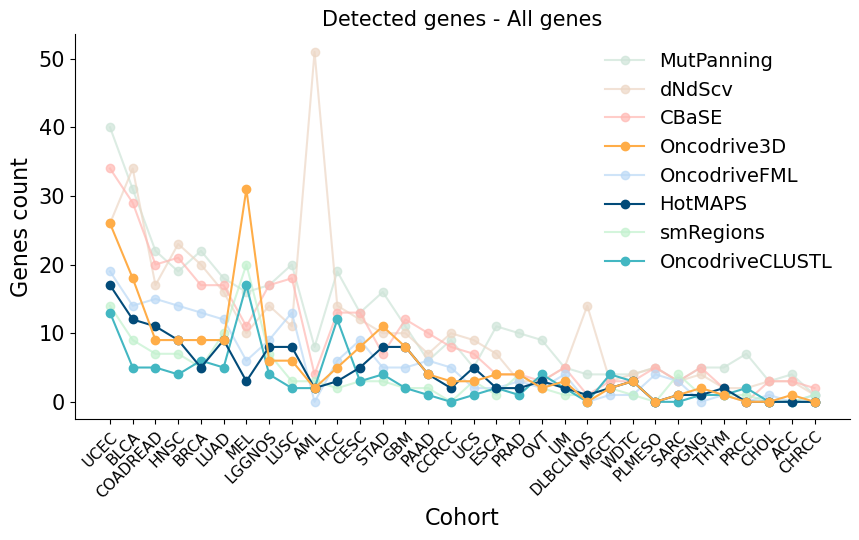

In [37]:
# TCGA colored
# ============

# Names and colors

colors_dic = {"Oncodrive3D" : "#ffad48", 
              "HotMAPS" : "#024b79", 
              "OncodriveCLUSTL" : "#43b7c2", 
              "smRegions" : "#c2f1ce", 
              "CBaSE" : "#ffb8b3", 
              "SEISMIC" : "#ede5ff", 
              "dNdScv" : "#edd7c5", 
              "MutPanning" : "#cee4d8", 
              "OncodriveFML" : "#bbd9f6",
              "Random" : "pink"}

names_dic = {"o3d" : "Oncodrive3D", 
             "hotmaps" : "HotMAPS", 
             "clustl" : "OncodriveCLUSTL", 
             "smreg" : "smRegions", 
             "cbase" : "CBaSE", 
             "seismic" : "SEISMIC", 
             "dndscv" : "dNdScv", 
             "mutpan" : "MutPanning", 
             "fml" : "OncodriveFML",
             "random" : "Random"}

## TCGA
df = genetable_subset.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# df = genetable_subset.copy()
# df = df.dropna(subset=[f"{name}_qval" for name in lst_methods])
# hits_df_overlap = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# All genes

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], 
                  names_dic, colors_dic,
                  smooth = False, 
                  figsize = (10, 5), 
                  title = "Detected genes - All genes", 
                  plot_xticks=True, 
                  rm_zero_rows=False, 
                  extract_cancer=True, 
                  ylabel="Genes count",
                  legend_fontsize = 14)

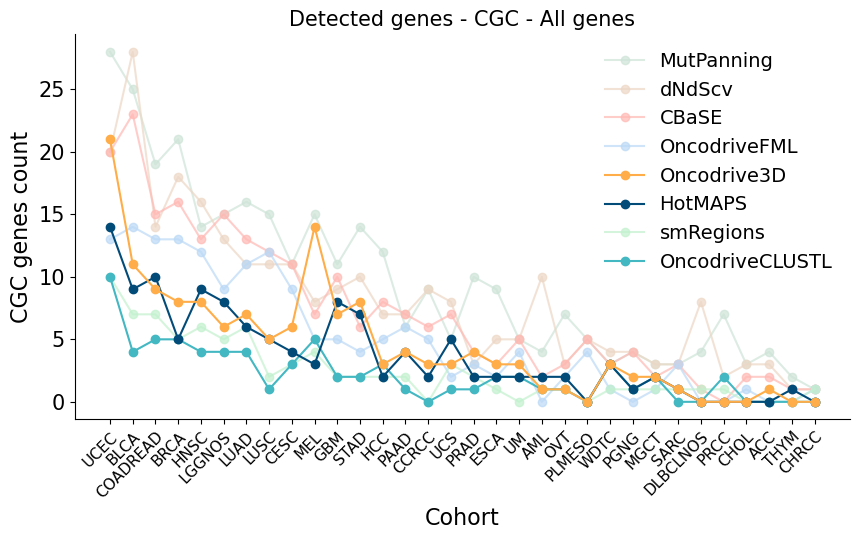

In [38]:
# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=True, rm_zero_rows=False, extract_cancer=True, legend_fontsize = 14,
                  ylabel="CGC genes count",
                  filename="plots/number_detected/cgc_hits_summary_tcga_colors.png")

# cols = [f"{name}_qval_cgc" for name in lst_methods]
# plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = False, figsize = (10, 5), title = "Detected genes - CGC - Genes overlap", 
#                   plot_xticks=True, rm_zero_rows=False, extract_cancer=True)

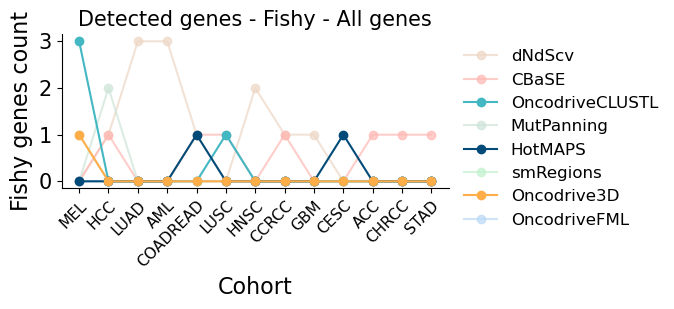

In [39]:
# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (5, 2), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=True, rm_zero_rows=True, extract_cancer=True,
                  ylabel="Fishy genes count",
                  filename="plots/number_detected/fishy_hits_summary_colors.png")

# cols = [f"{name}_qval_fish" for name in lst_methods]
# plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = False, figsize = (1.6, 1.5), title = "Detected genes - Fishy - Genes overlap", 
#                   plot_xticks=True, rm_zero_rows=True, extract_cancer=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.16it/s]


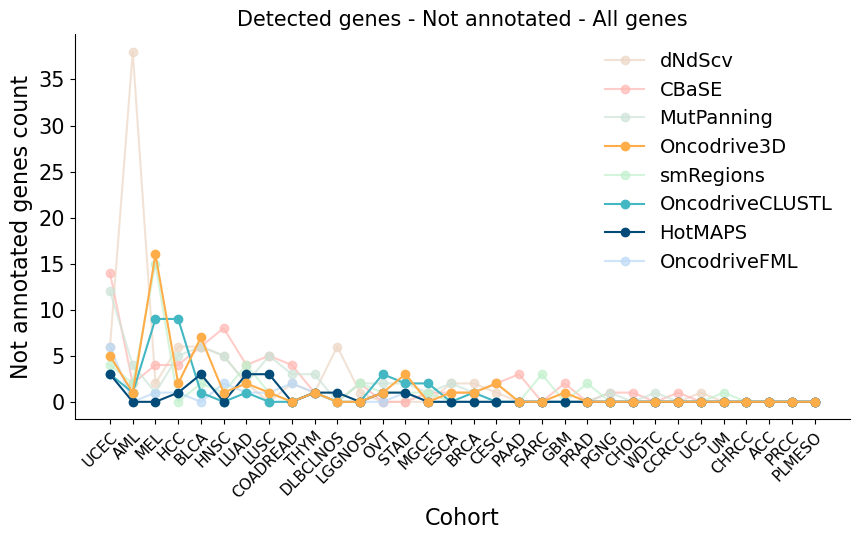

In [40]:
df = genetable_subset.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=True, unique=False)

# Not annotated

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], 
                  names_dic, colors_dic,
                  smooth = False, 
                  figsize = (10, 5), 
                  title = "Detected genes - Not annotated - All genes", 
                  plot_xticks=True, 
                  rm_zero_rows=False, 
                  extract_cancer=True, 
                  ylabel="Not annotated genes count",
                  legend_fontsize = 14)

### All cohorts

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:02<00:00, 61.09it/s]


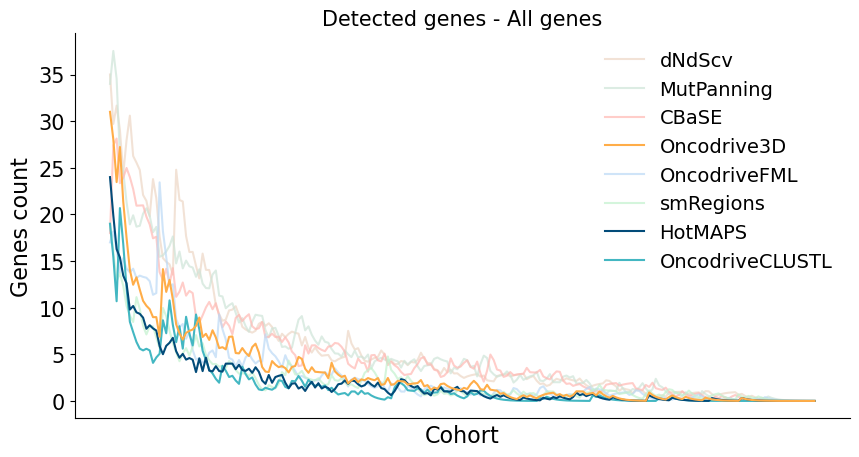

In [41]:
## All cohorts
df = genetable.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

df = df.dropna(subset=[f"{name}_qval" for name in lst_methods])
hits_df_overlap = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# All genes

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-",
                  legend_fontsize = 14,
                  ylabel="Genes count",
                  filename="plots/number_detected/hits_summary.png")

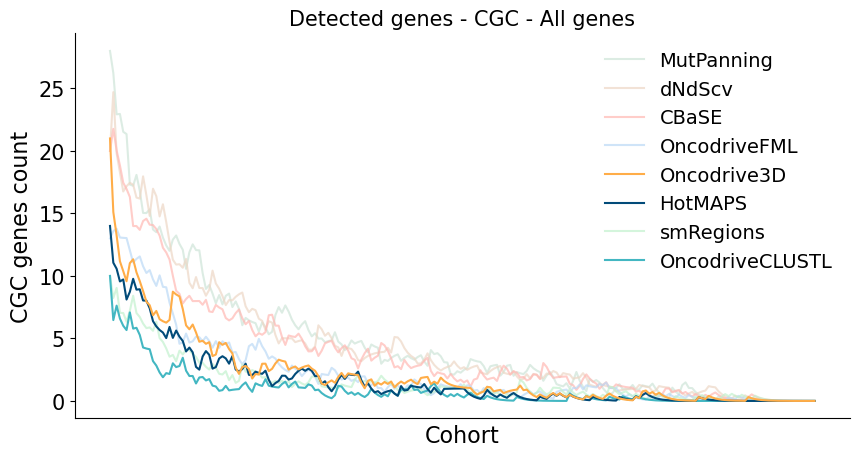

In [42]:
# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-",
                  legend_fontsize = 14,
                  ylabel="CGC genes count",
                  filename="plots/number_detected/cgc_hits_summary.png")

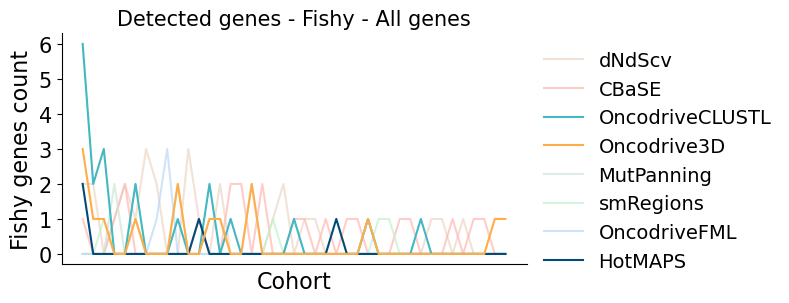

In [43]:
# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (6, 3), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=False, rm_zero_rows=True, style="-",
                  legend_fontsize = 14,
                  ylabel="Fishy genes count",
                  filename="plots/number_detected/cgc_hits_summary.png")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [01:17<00:00,  2.77it/s]


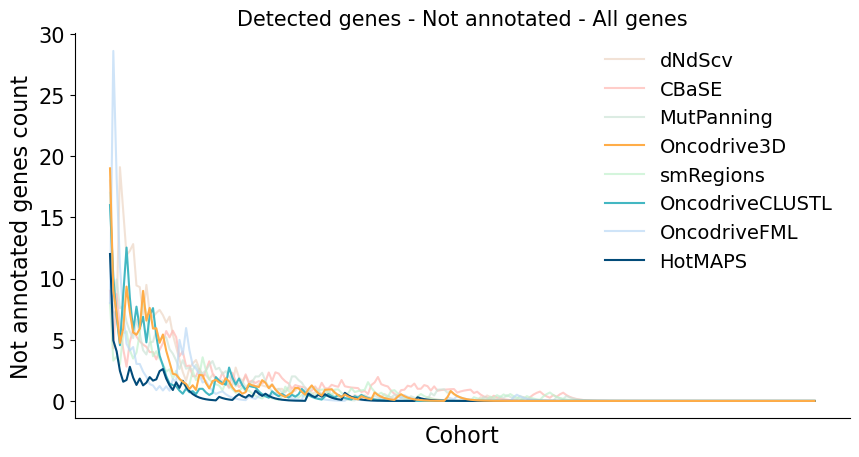

In [44]:
# Not annotated

df = genetable.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=True, unique=False)

cols = [f"{name}_qval" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), 
                  title = "Detected genes - Not annotated - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-",
                  legend_fontsize = 14,
                  ylabel="Not annotated genes count")

In [67]:
# # Names and colors

# colors_dic = {"Oncodrive3D" : "#ffad48", 
#               "HotMAPS" : "#024b79", 
#               "OncodriveCLUSTL" : "#43b7c2", 
#               "smRegions" : "#c2f1ce", 
#               "CBaSE" : "#ffb8b3", 
#               "SEISMIC" : "#ede5ff", 
#               "dNdScv" : "#edd7c5", 
#               "MutPanning" : "#cee4d8", 
#               "OncodriveFML" : "#bbd9f6",
#               "Random" : "pink"}

# names_dic = {"o3d" : "Oncodrive3D", 
#              "hotmaps" : "HotMAPS", 
#              "clustl" : "OncodriveCLUSTL", 
#              "smreg" : "smRegions", 
#              "cbase" : "CBaSE", 
#              "seismic" : "SEISMIC", 
#              "dndscv" : "dNdScv", 
#              "mutpan" : "MutPanning", 
#              "fml" : "OncodriveFML",
#              "random" : "Random"}


# ## TCGA
# df = genetable_subset.copy()
# hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# df = genetable_subset.copy()
# df = df.dropna(subset=[f"{name}_qval" for name in lst_methods])
# hits_df_overlap = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# # # Not annotated

# # cols = [f"{name}_qval" for name in lst_methods]
# # plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
# #                   smooth = False, figsize = (10, 5), title = "Detected genes - Not annotated - All genes", 
# #                   plot_xticks=True, rm_zero_rows=False, extract_cancer=True)

# # cols = [f"{name}_qval" for name in lst_methods]
# # plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
# #                   smooth = False, figsize = (10, 5), title = "Detected genes - Not annotated - Genes overlap", 
# #                   plot_xticks=True, rm_zero_rows=False, extract_cancer=True)

# # CGC

# cols = [f"{name}_qval_cgc" for name in lst_methods]
# plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = False, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
#                   plot_xticks=True, rm_zero_rows=False, extract_cancer=True,
#                   filename="cgc_hits_summary_tcga_all_methods_colors_07.png")


# # cols = [f"{name}_qval_cgc" for name in lst_methods]
# # plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
# #                   smooth = False, figsize = (10, 5), title = "Detected genes - CGC - Genes overlap", 
# #                   plot_xticks=True, rm_zero_rows=False, extract_cancer=True)

# # Fish

# cols = [f"{name}_qval_fish" for name in lst_methods]
# plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = False, figsize = (5, 2), title = "Detected genes - Fishy - All genes", 
#                   plot_xticks=True, rm_zero_rows=True, extract_cancer=True,
#                   filename="fishy_hits_summary_all_methods_colors_07.png")

# # cols = [f"{name}_qval_fish" for name in lst_methods]
# # plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
# #                   smooth = False, figsize = (1.6, 1.5), title = "Detected genes - Fishy - Genes overlap", 
# #                   plot_xticks=True, rm_zero_rows=True, extract_cancer=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 268/268 [02:19<00:00,  1.92it/s]


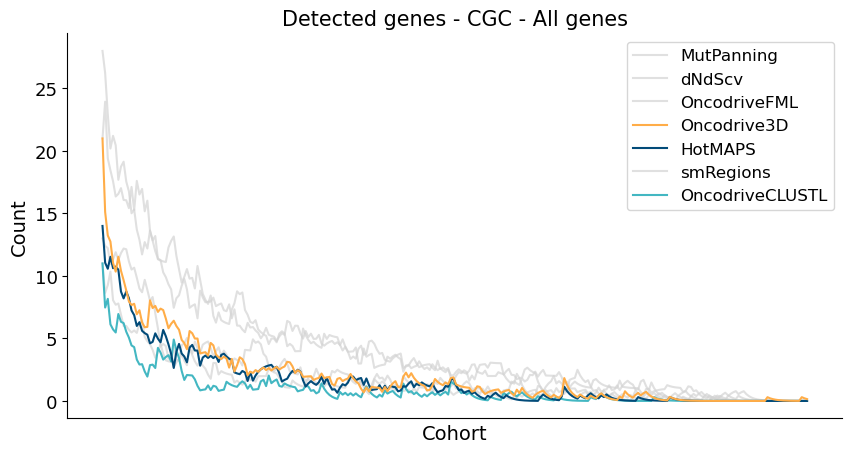

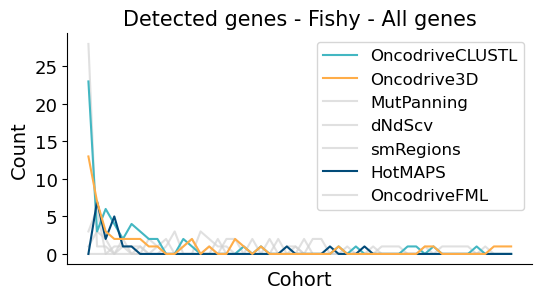

In [169]:
# New

## All cohorts
df = genetable.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# df = genetable.copy()
# df = df.dropna(subset=[f"{name}_qval" for name in lst_methods])
# hits_df_overlap = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# # Not annotated

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - All genes", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - Genes overlap", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-")

# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (6, 3), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=False, rm_zero_rows=True, style="-")

100%|██████████████████████████████████████████████████████████████████████████████████████| 215/215 [01:31<00:00,  2.36it/s]


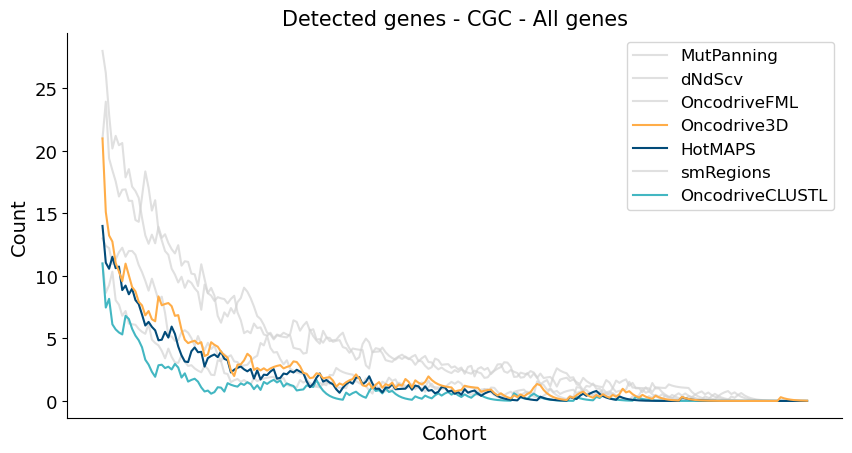

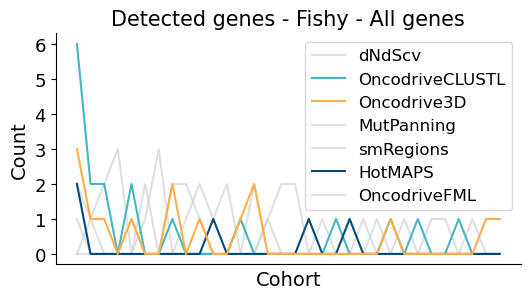

In [170]:
# New NO ICGC

## All cohorts
df = genetable_noicgc.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# df = genetable.copy()
# df = df.dropna(subset=[f"{name}_qval" for name in lst_methods])
# hits_df_overlap = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# # Not annotated

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - All genes", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - Genes overlap", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-")

# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = False, figsize = (6, 3), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=False, rm_zero_rows=True, style="-")

100%|██████████████████████████████████████████████████████████████████████████████████████| 262/262 [02:13<00:00,  1.96it/s]


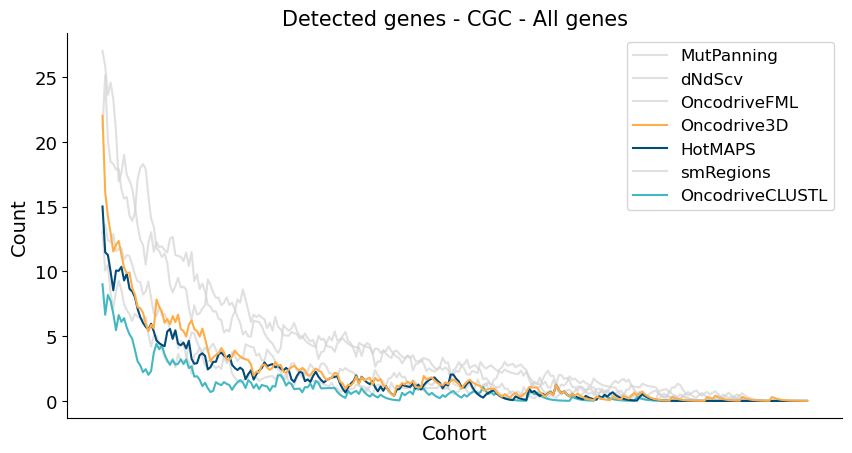

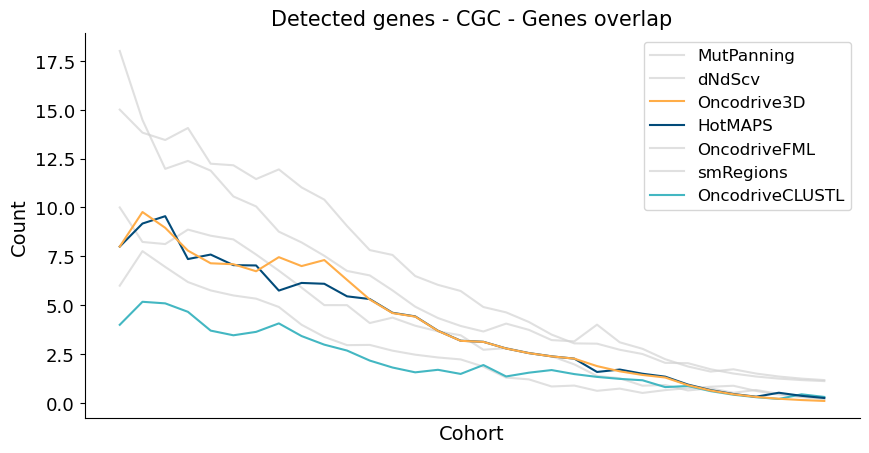

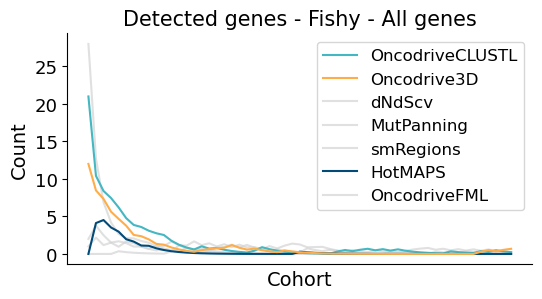

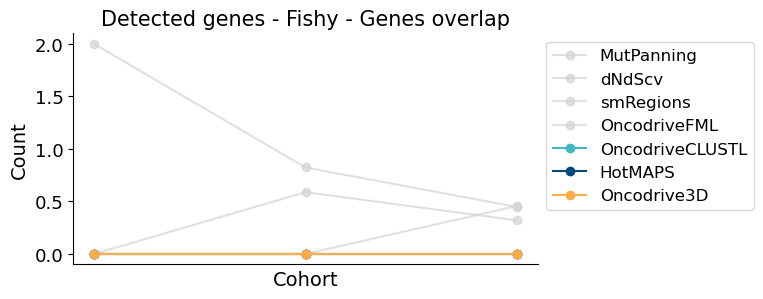

In [171]:
## Old

## All cohorts
df = genetable_old.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# df = genetable.copy()
# df = df.dropna(subset=[f"{name}_qval" for name in lst_methods])
# hits_df_overlap = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# # Not annotated

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - All genes", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - Genes overlap", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-")


cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - Genes overlap", 
                  plot_xticks=False, rm_zero_rows=False, style="-")

# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (6, 3), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=False, rm_zero_rows=True, style="-")

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (6, 3), title = "Detected genes - Fishy - Genes overlap", 
                  plot_xticks=False, rm_zero_rows=True, style="o-")

In [172]:
## Old

## All cohorts
df = genetable_old_noicgc.copy()
hits_df = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# df = genetable.copy()
# df = df.dropna(subset=[f"{name}_qval" for name in lst_methods])
# hits_df_overlap = get_hits_summary_lst_cohorts(df, lst_methods, unknown=False, unique=False)

# # Not annotated

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - All genes", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# cols = [f"{name}_qval" for name in lst_methods]
# plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
#                   smooth = True, figsize = (10, 5), title = "Detected genes - Not annotated - Genes overlap", 
#                   plot_xticks=False, rm_zero_rows=False, style="-")

# CGC

cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - All genes", 
                  plot_xticks=False, rm_zero_rows=False, style="-")


cols = [f"{name}_qval_cgc" for name in lst_methods]
plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (10, 5), title = "Detected genes - CGC - Genes overlap", 
                  plot_xticks=False, rm_zero_rows=False, style="-")

# Fish

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (6, 3), title = "Detected genes - Fishy - All genes", 
                  plot_xticks=False, rm_zero_rows=True, style="-")

cols = [f"{name}_qval_fish" for name in lst_methods]
plot_hits_summary(hits_df_overlap[["Cohort"] + cols], names_dic, colors_dic,
                  smooth = True, figsize = (6, 3), title = "Detected genes - Fishy - Genes overlap", 
                  plot_xticks=False, rm_zero_rows=True, style="o-")

NameError: name 'genetable_old_noicgc' is not defined

# CH

In [287]:
genetables_path = "/workspace/projects/clustering_3d/evaluation/genetables_dir/run_20230512_ch/OTHER_WXS_CH_IMPACT_PANEL.genetable.tsv"
df = pd.read_csv(genetables_path, sep="\t")
df = df.rename(columns={"3dclust_pval" : "o3d_pval",
                       "3dclust_qval" : "o3d_qval",
                       "3dclust_rank" : "o3d_rank",
                       "Fishy_Genes" : "Fish"})
df["Cohort"] = "OTHER_WXS_CH_IMPACT_PANEL"
df = df.drop(columns=["CGC"]).rename(columns={"CH" : "CGC"})
df

o3d_rank          Gene Uniprot_ID  3d_status  CGC  Fish Cancer  \
0           0.0        DNMT3A     Q9Y6K1  Processed    1     0     CH   
1           1.0         SF3B1     O75533  Processed    1     0     CH   
2           2.0          JAK2     O60674  Processed    1     0     CH   
3           3.0          GNAS     Q5JWF2  Processed    1     0     CH   
4           4.0         SRSF2     Q01130  Processed    1     0     CH   
...         ...           ...        ...        ...  ...   ...    ...   
20760       NaN       TMEM247        NaN        NaN    0     0    NaN   
20761       NaN         TTLL8        NaN        NaN    0     1    NaN   
20762       NaN        TXNRD3        NaN        NaN    0     0    NaN   
20763       NaN      USP17L23        NaN        NaN    0     0    NaN   
20764       NaN  ZNF511-PRAP1        NaN        NaN    0     0    NaN   

       o3d_pval  o3d_qval  cbase_rank  ...  clustl_rank   clustl_pval  \
0           0.0       0.0         2.0  ...          1.0  1.110223e-19   
1           0.0       0.0        19.0  ...          4.0  1.110223e-19   
2           0.0       0.0         6.0  ...          0.0  1.110223e-19   
3           0.0       0.0        20.0  ...          8.0  7.817272e-10   
4           0.0       0.0        13.0  ...          2.0  1.110223e-19   
...         ...       ...         ...  ...          ...           ...   
20760       NaN       NaN         NaN  ...      17006.0           NaN   
20761       NaN       NaN         NaN  ...      17655.0           NaN   
20762       NaN       NaN         NaN  ...      17738.0           NaN   
20763       NaN       NaN         NaN  ...      18012.0           NaN   
20764       NaN       NaN         NaN  ...      18963.0           NaN   

        clustl_qval  fml_rank  fml_pval  fml_qval  smreg_rank    smreg_pval  \
0      3.264056e-18       0.0  0.000001  0.000028         0.0  6.513607e-94   
1      3.264056e-18      18.0  0.000075  0.001642         NaN           NaN   
2      3.264056e-18       9.0  0.000001  0.000028         2.0  5.310583e-42   
3      1.276821e-08      13.0  0.000001  0.000028         3.0  3.561379e-25   
4      3.264056e-18      10.0  0.000001  0.000028         NaN           NaN   
...             ...       ...       ...       ...         ...           ...   
20760           NaN       NaN       NaN       NaN         NaN           NaN   
20761           NaN       NaN       NaN       NaN         NaN           NaN   
20762           NaN       NaN       NaN       NaN         NaN           NaN   
20763           NaN       NaN       NaN       NaN         NaN           NaN   
20764           NaN       NaN       NaN       NaN         NaN           NaN   

         smreg_qval                     Cohort  
0      3.302399e-91  OTHER_WXS_CH_IMPACT_PANEL  
1               NaN  OTHER_WXS_CH_IMPACT_PANEL  
2      8.974885e-40  OTHER_WXS_CH_IMPACT_PANEL  
3      4.514048e-23  OTHER_WXS_CH_IMPACT_PANEL  
4               NaN  OTHER_WXS_CH_IMPACT_PANEL  
...             ...                        ...  
20760           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20761           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20762           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20763           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20764           NaN  OTHER_WXS_CH_IMPACT_PANEL  

[20765 rows x 31 columns]

In [288]:
lst_methods.remove("seismic")
lst_methods.remove("mutpan")

In [290]:
df

o3d_rank          Gene Uniprot_ID  3d_status  CGC  Fish Cancer  \
0           0.0        DNMT3A     Q9Y6K1  Processed    1     0     CH   
1           1.0         SF3B1     O75533  Processed    1     0     CH   
2           2.0          JAK2     O60674  Processed    1     0     CH   
3           3.0          GNAS     Q5JWF2  Processed    1     0     CH   
4           4.0         SRSF2     Q01130  Processed    1     0     CH   
...         ...           ...        ...        ...  ...   ...    ...   
20760       NaN       TMEM247        NaN        NaN    0     0    NaN   
20761       NaN         TTLL8        NaN        NaN    0     1    NaN   
20762       NaN        TXNRD3        NaN        NaN    0     0    NaN   
20763       NaN      USP17L23        NaN        NaN    0     0    NaN   
20764       NaN  ZNF511-PRAP1        NaN        NaN    0     0    NaN   

       o3d_pval  o3d_qval  cbase_rank  ...  clustl_rank   clustl_pval  \
0           0.0       0.0         2.0  ...          1.0  1.110223e-19   
1           0.0       0.0        19.0  ...          4.0  1.110223e-19   
2           0.0       0.0         6.0  ...          0.0  1.110223e-19   
3           0.0       0.0        20.0  ...          8.0  7.817272e-10   
4           0.0       0.0        13.0  ...          2.0  1.110223e-19   
...         ...       ...         ...  ...          ...           ...   
20760       NaN       NaN         NaN  ...      17006.0           NaN   
20761       NaN       NaN         NaN  ...      17655.0           NaN   
20762       NaN       NaN         NaN  ...      17738.0           NaN   
20763       NaN       NaN         NaN  ...      18012.0           NaN   
20764       NaN       NaN         NaN  ...      18963.0           NaN   

        clustl_qval  fml_rank  fml_pval  fml_qval  smreg_rank    smreg_pval  \
0      3.264056e-18       0.0  0.000001  0.000028         0.0  6.513607e-94   
1      3.264056e-18      18.0  0.000075  0.001642         NaN           NaN   
2      3.264056e-18       9.0  0.000001  0.000028         2.0  5.310583e-42   
3      1.276821e-08      13.0  0.000001  0.000028         3.0  3.561379e-25   
4      3.264056e-18      10.0  0.000001  0.000028         NaN           NaN   
...             ...       ...       ...       ...         ...           ...   
20760           NaN       NaN       NaN       NaN         NaN           NaN   
20761           NaN       NaN       NaN       NaN         NaN           NaN   
20762           NaN       NaN       NaN       NaN         NaN           NaN   
20763           NaN       NaN       NaN       NaN         NaN           NaN   
20764           NaN       NaN       NaN       NaN         NaN           NaN   

         smreg_qval                     Cohort  
0      3.302399e-91  OTHER_WXS_CH_IMPACT_PANEL  
1               NaN  OTHER_WXS_CH_IMPACT_PANEL  
2      8.974885e-40  OTHER_WXS_CH_IMPACT_PANEL  
3      4.514048e-23  OTHER_WXS_CH_IMPACT_PANEL  
4               NaN  OTHER_WXS_CH_IMPACT_PANEL  
...             ...                        ...  
20760           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20761           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20762           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20763           NaN  OTHER_WXS_CH_IMPACT_PANEL  
20764           NaN  OTHER_WXS_CH_IMPACT_PANEL  

[20765 rows x 31 columns]

In [291]:
plot_hits_barplot(df, lst_methods, names_dic, title="Detected CH genes-cohorts - OTHER_WXS_CH_IMPACT_PANEL\n", filename="hits_stacked_barplot_ch")